Resumo Final do Case – Academia Santander
🎯 Objetivo

Resolver um problema de negócios atuando como cientista de dados, cobrindo:

Extração e ingestão da base (Kaggle → Spark, Colab, Databricks etc.)

Análise exploratória

Resolução de um desafio supervisionado (Churn ou Rentabilidade)

Resolução de um desafio não supervisionado (segmentação, perfis etc.)

Justificação das análises, premissas, métodos escolhidos e resultados de negócio

📂 Bases

transactions.csv: histórico de pagamento, plano, preço, cancelamento

members_v3.csv: dados cadastrais (cidade, idade com outliers, gênero, registro)

user_logs.csv: uso diário (quantidade de músicas tocadas em frações de duração)

🧩 Desafios de Negócio
A) Churn (proativo)

Hoje: ação reativa → cliente que não renova ganha 3 meses grátis.

Proposta: modelo preditivo para prever churn em 3 meses (ativo em M e inativo em M+3).

Avaliar impacto: assumindo que 50% dos verdadeiros positivos ficam ativos +1 ano.

Entregas mínimas:

Target (com regra 3M)

Feature Engineering

Seleção de variáveis

Modelagem

Medida do impacto (clientes retidos + resultado financeiro)

B) Rentabilidade

Custos:

𝐶
(
𝑢
,
𝑡
)
=
50
+
0.0051
𝑢
+
0.0001
𝑡
C(u,t)=50+0.0051u+0.0001t

(u = músicas únicas, t = tempo em segundos no mês).

Modelo para estimar Margem Líquida (Preço – Custo).

Avaliar performance em M+1.

Conclusões sobre resultados.

C) Não Supervisionado

Análise de perfis de clientes para complementar o problema escolhido.

Direções sugeridas:

Perfis de uso vs churn/rentabilidade

Volatilidade e incerteza dos clientes

Erros dos modelos supervisionados

Variação temporal

📌 Entregáveis

Obrigatório: Notebook exportado em .html (código organizado, comentado).

Opcional: PPT com problema, insights, modelo e resultados.

Durante a apresentação → mostrar o código, explicar técnicas, justificar escolhas, citar alternativas (mesmo as não usadas).

⏱️ Apresentação

Tempo: 1h30 (case + perguntas).

Mostrar pipeline completo (dataprep → EDA → target → FE → modelo → métricas → resultado de negócio).

Linguagem clara, com começo-meio-fim, conectando técnico + negócio.

🧾 Critérios de Avaliação

EDA: hipóteses claras, implicações.

Dataprep: missing, outliers, volumetria.

Feature Engineering/Selection: novas variáveis, variáveis relevantes.

Modelagem: funcionamento do algoritmo, hiperparâmetros, forças/fraquezas.

Validação: evitar leakage, usar cross-validation, explicar escolha.

Resultados: métricas adequadas, impacto de negócio.

Código: claro, organizado, modular, versionado.

Apresentação: tempo, clareza, soft skills.

Viés & Variância: conhecimento transversal exigido em todas etapas.

# Preparo notebook


In [1]:
!pip install optbinning


In [2]:
from pyspark.sql import SparkSession

# Inicia uma sessão Spark
spark = SparkSession.builder.appName("ColabSpark").getOrCreate()

print("Sessão Spark iniciada com sucesso!")

Sessão Spark iniciada com sucesso!


In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


In [4]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [5]:
!apt-get update -qq
!apt-get install -y -qq openjdk-17-jdk-headless
!pip install -q pyspark==3.5.1 findspark py4j==0.10.9.7

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [6]:
import os, findspark
# Garanta Java 17 e Python 3
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-17-openjdk-amd64"
os.environ["PYSPARK_PYTHON"] = "python3"
os.environ["PYSPARK_DRIVER_PYTHON"] = "python3"

# (Se você já setou SPARK_HOME antes, limpe para evitar conflito)
os.environ.pop("SPARK_HOME", None)

findspark.init()

In [7]:
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder
    .appName("ChurnCase")
    .master("local[*]")  # usa todos os cores
    # Memória do driver — ajuste se necessário (ex.: "20g")
    .config("spark.driver.memory", "16g")
    # Serializer rápido
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer")
    # Adaptive Query Execution (ajusta planos/partições em runtime)
    .config("spark.sql.adaptive.enabled", "true")
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true")
    .config("spark.sql.adaptive.skewJoin.enabled", "true")
    # Shuffle partitions (base): diminua/ajuste se operações ficam lentas
    .config("spark.sql.shuffle.partitions", "200")
    # Broadcast joins p/ dimensões médias
    .config("spark.sql.autoBroadcastJoinThreshold", "64MB")
    # Compressões
    .config("spark.io.compression.codec", "lz4")
    .config("spark.sql.parquet.compression.codec", "zstd")
    # Parquet otimizações
    .config("spark.sql.parquet.mergeSchema", "false")
    .config("spark.sql.parquet.filterPushdown", "true")
    .config("spark.sql.files.maxPartitionBytes", str(256 * 1024 * 1024))  # ~256MB p/ partição
    # Pandas <-> Arrow (quando for coletar amostras para gráficos)
    .config("spark.sql.execution.arrow.pyspark.enabled", "true")
    # UI menos verbosa
    .config("spark.ui.showConsoleProgress", "false")
    .getOrCreate()
)

spark.sparkContext.setLogLevel("WARN")
print("Spark:", spark.version)


Spark: 3.5.1


In [8]:
import kagglehub
import os
from pyspark.sql import functions as F
from pyspark.sql.functions import col, isnan, when, count,  to_date, year, month, datediff, concat_ws, lit, last_day,  mean, stddev, min, max
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


#Importação de Dados


Origem dados: Kaggle - importação via kaggle


In [ ]:
# baixar dados da pasta do data master
path = kagglehub.dataset_download("gcenachi/case-data-master-2024")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'case-data-master-2024' dataset.
Path to dataset files: /kaggle/input/case-data-master-2024


avaliação arquivos disponíveis no diretório Kaggle

In [ ]:
# Ver tudo que foi baixado
print("Arquivos encontrados:")
for root, dirs, files in os.walk(path):
    for file in files:
        print(os.path.join(root, file))

Arquivos encontrados:
/kaggle/input/case-data-master-2024/members.parquet
/kaggle/input/case-data-master-2024/user_logs.parquet
/kaggle/input/case-data-master-2024/transactions.parquet


In [ ]:
print("DIretório dos dados: "+path)

DIretório dos dados: /kaggle/input/case-data-master-2024


In [ ]:
#leitura dos dados
df_transactions = spark.read.parquet(f"{path}/transactions.parquet")
df_members = spark.read.parquet(f"{path}/members.parquet")
df_user_logs = spark.read.parquet(f"{path}/user_logs.parquet")

In [ ]:
df_transactions.show(5)
df_members.show(5)
df_user_logs.show(5)

+--------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+
|                msno|payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel| safra|
+--------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+
|+++IZseRRiQS9aaSk...|               38|              410|           1788|              1788|            0|        20151121|              20170104|        0|201511|
|+++snpr7pmobhLKUg...|               41|               30|            149|               149|            1|        20150526|              20150626|        0|201505|
|+++snpr7pmobhLKUg...|               41|               30|            149|               149|            1|        20150926|              20151026|        0|201509|
|++/9R3sX3

* A base transactions possui informações de registros de pagamentos, valores, datas de transação
* A base member possui informaçoes de registro e demograficas dos clientes
* A base user logs possui informaões de uso da plataforma pelos clientes

Avaliação quantidade de registros por Safra

In [ ]:

 df_members.groupBy("safra").count().orderBy("safra").show()


+------+-------+
| safra|  count|
+------+-------+
|201601|4294184|
|201602|4502354|
|201603|4697972|
|201604|4876301|
|201605|5060705|
|201606|5250064|
|201607|5439337|
|201608|5615921|
|201609|5778986|
|201610|5949288|
|201611|6114345|
|201612|6287789|
+------+-------+



In [ ]:
df_transactions.groupBy("safra").count().orderBy("safra").show(100)


+------+-------+
| safra|  count|
+------+-------+
|201501| 548792|
|201502| 545303|
|201503| 626488|
|201504| 564582|
|201505| 571552|
|201506| 775737|
|201507| 665280|
|201508| 705975|
|201509| 714610|
|201510| 680465|
|201511| 820345|
|201512| 861107|
|201601| 856716|
|201602| 792300|
|201603| 775469|
|201604| 774169|
|201605| 783956|
|201606| 804729|
|201607| 924032|
|201608| 966450|
|201609| 982640|
|201610|1033898|
|201611|1094941|
|201612| 968547|
|201701| 988576|
|201702| 885566|
+------+-------+



In [ ]:
df_user_logs.groupBy("safra").count().orderBy("safra").show(100)


+------+-------+
| safra|  count|
+------+-------+
|201501| 937789|
|201502| 933040|
|201503| 944739|
|201504| 939930|
|201505| 924216|
|201506| 916862|
|201507| 871491|
|201508| 920129|
|201509| 903194|
|201510|1012953|
|201511|1041975|
|201512|1039271|
|201601|1076712|
|201602|1041248|
|201603|1048941|
|201604|1042406|
|201605|1056491|
|201606|1081181|
|201607|1102807|
|201608|1103078|
|201609|1112601|
|201610|1139089|
|201611|1183088|
|201612|1135573|
|201701|1136003|
|201702|1114164|
+------+-------+



In [ ]:
df_transactions.count()

20712225

In [ ]:
df_members.count()

63867246

In [ ]:
df_user_logs.count()

26758971

In [ ]:
#avaliação se há duplicatas nos registros por membro dentro de uma mesma safra
# print(df_members.filter(F.col("safra") == 201612 ).select("msno").distinct().count())
# print(df_members.filter(F.col("safra") == 201612).count())

In [ ]:
df_user_logs.count()

26758971

A base members possuí registros mensais de todas as safras de 2016. As outras bases possuem registros de 12m antes da primeira safra de members e 3 meses após a última.

In [ ]:
df_members.show()

+--------------------+------+----------------------+----+---+------+--------------+--------+
|                msno| safra|registration_init_time|city| bd|gender|registered_via|is_ativo|
+--------------------+------+----------------------+----+---+------+--------------+--------+
|+++snpr7pmobhLKUg...|201612|              20140927|   1|  0|  NULL|             7|       1|
|++/AwGzubug3gT6J+...|201607|              20150322|   1|  0|  NULL|             9|       0|
|++/Gw1B9K+XOlB3hL...|201601|              20121217|  15| 32|  male|             3|       1|
|++02XbtviomSxcIBU...|201603|              20131112|  14| 21|  male|             7|       0|
|++0O0Bq04sB/9ZcOS...|201610|              20141021|   5| 33|  male|             3|       0|
|++2AQgVgYUAqJDw68...|201608|              20150416|  18| 23|  male|             3|       0|
|++2gRJ7i2MbO6qUG6...|201608|              20140616|  11| 33|  male|             7|       0|
|++3brN43Yd6GURegT...|201604|              20100512|  14| 19|  male|  

# Avaliação da target

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType

# --- Helpers ----
# yyyymm (int) -> primeira data do mês
def yyyymm_to_date(yyyymm: int) -> str:
    y = yyyymm // 100
    m = yyyymm % 100
    return f"{y:04d}-{m:02d}-01"

yyyymm_to_date_udf = F.udf(lambda x: yyyymm_to_date(int(x)))

# Soma k meses a yyyymm (int) -> yyyymm (int)
def add_months_int(yyyymm: int, k: int) -> int:
    y = yyyymm // 100
    m = yyyymm % 100
    m2 = m + k
    y += (m2 - 1) // 12
    m = ((m2 - 1) % 12) + 1
    return y * 100 + m

add_months_int_udf = F.udf(lambda x, k: add_months_int(int(x), int(k)), IntegerType())

# --- Garantir tipos ---
df_members = (df_members
              .withColumn("safra", F.col("safra").cast("int"))
              .withColumn("is_ativo", F.col("is_ativo").cast("int")))

# 1) Painel-âncora: somente 2016 (onde há members mensais completos)
panel = (df_members
         .filter((F.col("safra") >= 201601) & (F.col("safra") <= 201612))
         .select("msno", "safra", "is_ativo")
         .dropDuplicates())

# 2) Tabela deslocada -3 meses para colar o status de M+3 na linha de M
#    churn_m3 = 0 se is_ativo(M+3) == 1; 1 caso contrário
members_m3 = (df_members
              .withColumn("churn", F.when(F.col("is_ativo") == 1, F.lit(0)).otherwise(F.lit(1)))
              # desloca a safra 3 meses para TRÁS para alinhar com M
              .withColumn("safra", add_months_int_udf(F.col("safra"), F.lit(-3)))
              .select(F.col("msno"),
                      F.col("safra").alias("safra_M"),  # essa safra_M é a original M (porque deslocamos -3)
                      F.col("churn").alias("churn_Mplus3"))
             )

# 3) Mantemos apenas M onde o cliente está ATIVO e onde existe observabilidade de M+3
#    Como members só cobre 2016, excluímos 201610–201612 (pois M+3 cairia em 2017, sem members)
base_M = (panel
          .filter((F.col("is_ativo") == 1) &
                  (~F.col("safra").isin(201610, 201611, 201612)))
          .select("msno", "safra"))

# 4) Juntar para trazer a coluna churn (status em M+3) alinhada em M
df_target = (base_M.join(members_m3,
                         (base_M.msno == members_m3.msno) & (base_M.safra == members_m3.safra_M),
                         how="left")
                    .select(base_M.msno,
                            base_M.safra,
                            F.coalesce(F.col("churn_Mplus3"), F.lit(1)).alias("target"))  # se não achou M+3, considere churn=1 ou ajuste conforme sua política
           )

# (opcional) Se preferir descartar casos sem M+3 (ao invés de imputar 1), use:
# df_target = df_target.na.drop(subset=["target"])


In [ ]:
 # Amostra 30% de msno (distintos) para reduzir a base
distinct_users = df_target.select("msno").distinct()

sample_users = (distinct_users
                .orderBy(F.rand(seed=42))
                .limit(int(distinct_users.count() * 0.3)))
# Alternativa mais rápida em grandes volumes:
# sample_users = distinct_users.sample(withReplacement=False, fraction=0.3, seed=42)

# Mantém todas as safras dos usuários sorteados (evita vazamento de usuário entre treino/teste)
df_target_sample = (df_target.join(sample_users, on="msno", how="inner"))

# Checagem rápida
df_target.groupBy("target").count().orderBy("target").show()
df_target_sample.groupBy("target").count().orderBy("target").show()


+------+-------+
|target|  count|
+------+-------+
|     0|6996370|
|     1|1148026|
+------+-------+

+------+-------+
|target|  count|
+------+-------+
|     0|2098520|
|     1| 343967|
+------+-------+



In [ ]:
df_target_sample.show()

+--------------------+------+------+
|                msno| safra|target|
+--------------------+------+------+
|++4yteQFM9k0Gjq5f...|201607|     1|
|++9l7+WGOZ96gNp0T...|201606|     0|
|++AH7m/EQ4iKe6wSl...|201609|     0|
|++BBU1qnsavj2eC5j...|201607|     0|
|++I1wsXaVBTTZE3gw...|201605|     1|
|++OepqRK4wiYg4Chl...|201601|     0|
|++UrWpg7IekInPcWf...|201609|     0|
|++aVm+4v87MXzbhiE...|201606|     0|
|++hyrFWjxq/OrIQ51...|201606|     1|
|++nIX8NDXEAJy50QA...|201601|     0|
|+/7ve+lDyAbU/xuRj...|201602|     0|
|+/8IMQ9wN6Q+2BNlO...|201601|     0|
|+/8IMQ9wN6Q+2BNlO...|201603|     0|
|+/9/HGSaslo33sBW1...|201609|     0|
|+/AKFEKuCbv70A9AG...|201603|     0|
|+/SKX44s4ryWQzYzu...|201605|     0|
|+/So7HwYuITjx2GF0...|201608|     0|
|+/ePfJGkzAegKh12k...|201608|     0|
|+/evMkY4VIs+qVJSv...|201609|     0|
|+/is/5hKXj7dKIjfn...|201606|     0|
+--------------------+------+------+
only showing top 20 rows



In [ ]:
# # Salvar a base df_target_sample no Google Drive
# output_path = "/content/drive/MyDrive/Colab Notebooks/df_target_sample.parquet"

# # Salva o DataFrame no formato Parquet
# df_target_sample.write.mode("overwrite").parquet(output_path)

# print(f"DataFrame salvo em: {output_path}")

DataFrame salvo em: /content/drive/MyDrive/Colab Notebooks/df_target_sample.parquet


In [ ]:
import os
from google.colab import drive

# === 1️⃣ Monta o Google Drive (se ainda não estiver montado) ===
if not os.path.exists("/content/drive/MyDrive"):
    print("🔗 Montando o Google Drive...")
    drive.mount('/content/drive')
else:
    print("✅ Google Drive já montado.")

# === 2️⃣ Define o caminho de saída ===
output_dir = "/content/drive/MyDrive/DataMaster/dm"
os.makedirs(output_dir, exist_ok=True)  # cria a pasta se não existir

# === 3️⃣ Verifica se o caminho é acessível e gravável ===
if os.access(output_dir, os.W_OK):
    print(f"📂 Pasta de saída confirmada: {output_dir}")
else:
    raise PermissionError(f"❌ Sem permissão de escrita em {output_dir}. Verifique se o Drive está montado corretamente.")

# === 4️⃣ Caminho do arquivo final ===
output_path = os.path.join(output_dir, "df_target_sample.parquet")

# === 5️⃣ Salva com segurança ===
try:
    df_target_sample.write.mode("overwrite").parquet(output_path)
    print(f"✅ DataFrame salvo com sucesso em:\n   {output_path}")
except Exception as e:
    print(f"❌ Erro ao salvar o arquivo: {e}")

# === 6️⃣ (Opcional) Verifica se o arquivo realmente existe no Drive ===
if os.path.exists(output_path):
    print("🟢 Verificação OK: o arquivo está salvo no Drive.")
else:
    print("⚠️ Atenção: o arquivo não foi encontrado após o salvamento — confira se o Drive está montado.")


✅ Google Drive já montado.
📂 Pasta de saída confirmada: /content/drive/MyDrive/DataMaster/dm
✅ DataFrame salvo com sucesso em:
   /content/drive/MyDrive/DataMaster/dm/df_target_sample.parquet
🟢 Verificação OK: o arquivo está salvo no Drive.


# Nova seção

In [ ]:
# # Salvar a base df_target_sample no Google Drive
# output_path = "/content/drive/MyDrive/DataMaster/dm/df_target_sample.parquet"

# # Salva o DataFrame no formato Parquet
# df_target_sample.write.mode("overwrite").parquet(output_path)

# print(f"DataFrame salvo em: {output_path}")

DataFrame salvo em: /content/drive/MyDrive/DataMaster/dm/df_target_sample.parquet


## Avaliação

In [ ]:
# Ler a base df_target_sample do Google Drive
input_path = "/content/drive/MyDrive/DataMaster/dm/df_target_sample.parquet"

# Lê o DataFrame do formato Parquet
df_target= spark.read.parquet(input_path)

print(f"DataFrame lido de: {input_path}")
df_target.show(5)

DataFrame lido de: /content/drive/MyDrive/DataMaster/dm/df_target_sample.parquet
+--------------------+------+------+
|                msno| safra|target|
+--------------------+------+------+
|++9l7+WGOZ96gNp0T...|201602|     0|
|++FojTWzKjhz7uxsZ...|201602|     0|
|++KFxeVAa6Q5C1dJk...|201604|     0|
|++UrWpg7IekInPcWf...|201607|     0|
|++hTNyKbQJonbwH4z...|201609|     0|
+--------------------+------+------+
only showing top 5 rows



In [ ]:
df_target.count()

2442487

In [ ]:
total_count = df_target.count()
target_one_count = df_target.filter(col("target") == 1).count()

target_one_rate = (target_one_count / total_count) * 100 if total_count > 0 else 0

print(f"Total de registros: {total_count}")
print(f"Registros com target = 1: {target_one_count}")
print(f"Taxa de target = 1: {target_one_rate:.2f}%")

Total de registros: 2442487
Registros com target = 1: 343967
Taxa de target = 1: 14.08%


In [ ]:
df_target_churn_rate_by_safra = df_target.groupBy("safra").agg(
    count("*").alias("total_registros"),
    F.sum(col("target")).alias("target_1_count") # Sum of target where target is 1
).withColumn(
    "pct_target_1",
    (col("target_1_count") / col("total_registros")) * 100
).orderBy("safra")

df_target_churn_rate_by_safra.show()

+------+---------------+--------------+------------------+
| safra|total_registros|target_1_count|      pct_target_1|
+------+---------------+--------------+------------------+
|201601|         266422|         54856|20.589891225199118|
|201602|         275270|         55331|20.100628473862024|
|201603|         261479|         41007|15.682712569651866|
|201604|         249497|         26633|10.674677451031474|
|201605|         254953|         29994|11.764521303926607|
|201606|         253385|         29108|11.487657122560531|
|201607|         290271|         31606|10.888445624950476|
|201608|         293942|         36789|12.515734396581637|
|201609|         297268|         38643|12.999381029912401|
+------+---------------+--------------+------------------+



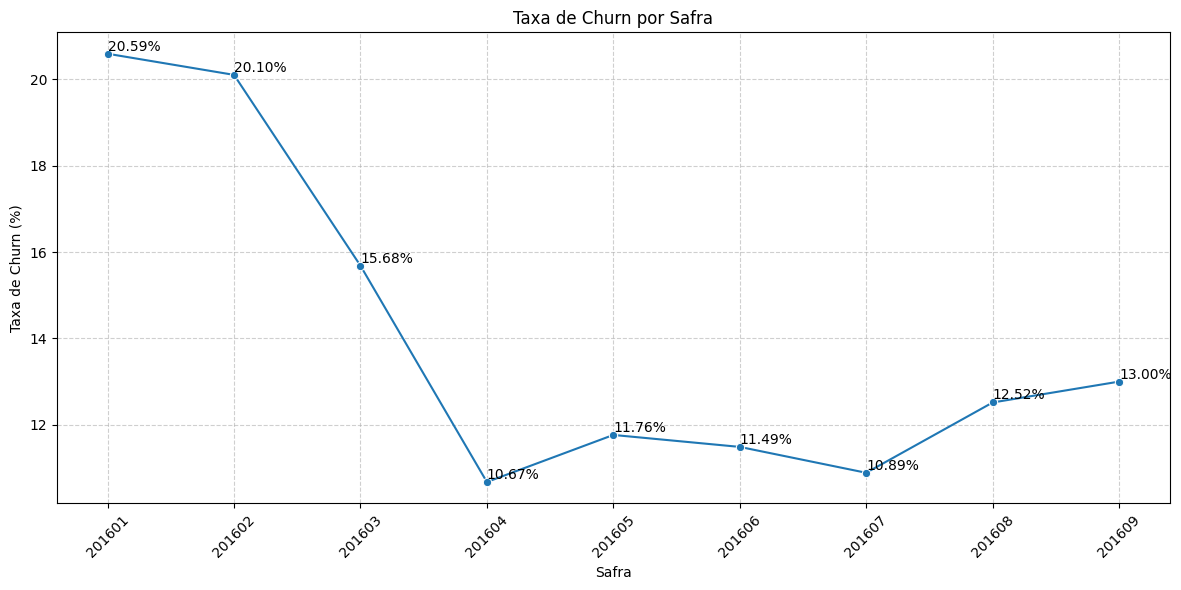

In [ ]:
df_churn_rate_pd = df_target_churn_rate_by_safra.toPandas()

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_churn_rate_pd, x="safra", y="pct_target_1", marker="o")

# Adicionar rótulos aos pontos
for index, row in df_churn_rate_pd.iterrows():
    plt.text(row["safra"], row["pct_target_1"], f'{row["pct_target_1"]:.2f}%', ha='left', va='bottom')

plt.title("Taxa de Churn por Safra")
plt.xlabel("Safra")
plt.ylabel("Taxa de Churn (%)")
plt.xticks(ticks=df_churn_rate_pd["safra"], labels=df_churn_rate_pd["safra"].astype(str), rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

* safras de 201601 a 201603 muito distantes. não serao consideradas


## amostragem outras bases

In [ ]:
# Criar um DataFrame com os msno distintos da base de target amostrada
distinct_msno_df = df_target.select("msno").distinct()

# Filtrar as bases originais usando os msno distintos
df_transactions_filtered = df_transactions.join(distinct_msno_df, on="msno", how="inner")
df_members_filtered = df_members.join(distinct_msno_df, on="msno", how="inner")
df_user_logs_filtered = df_user_logs.join(distinct_msno_df, on="msno", how="inner")

print(f"Número de msno distintos na base df_target: {distinct_msno_df.count()}")
print(f"Número de registros em df_transactions_filtered: {df_transactions_filtered.count()}")
print(f"Número de registros em df_members_filtered: {df_members_filtered.count()}")
print(f"Número de registros em df_user_logs_filtered: {df_user_logs_filtered.count()}")

Número de msno distintos na base df_target: 392912
Número de registros em df_transactions_filtered: 5038181
Número de registros em df_members_filtered: 4462667
Número de registros em df_user_logs_filtered: 6065878


In [ ]:
import os
from google.colab import drive

# === 1️⃣ Monta o Google Drive, se ainda não estiver montado ===
if not os.path.exists("/content/drive/MyDrive"):
    print("🔗 Montando o Google Drive...")
    drive.mount('/content/drive')
else:
    print("✅ Google Drive já está montado.")

# === 2️⃣ Define e garante a pasta de saída ===
output_dir = "/content/drive/MyDrive/DataMaster/dm"
os.makedirs(output_dir, exist_ok=True)

if not os.access(output_dir, os.W_OK):
    raise PermissionError(f"❌ Sem permissão de escrita em {output_dir}. Verifique o Drive.")

print(f"📂 Pasta de saída confirmada: {output_dir}")

# === 3️⃣ Função auxiliar pra salvar e validar ===
def safe_save(df, name):
    path = f"{output_dir}/{name}.parquet"
    try:
        df.write.mode("overwrite").parquet(path)
        if os.path.exists(path):
            print(f"✅ {name} salvo com sucesso em:\n   {path}")
        else:
            print(f"⚠️ Tentativa de salvar {name} não gerou arquivo. Verifique se o Drive está ativo.")
    except Exception as e:
        print(f"❌ Erro ao salvar {name}: {e}")

# === 4️⃣ Salvar os DataFrames ===
safe_save(df_transactions_filtered, "transactions_filtered")
safe_save(df_members_filtered, "members_filtered")
safe_save(df_user_logs_filtered, "user_logs_filtered")


✅ Google Drive já está montado.
📂 Pasta de saída confirmada: /content/drive/MyDrive/DataMaster/dm
✅ transactions_filtered salvo com sucesso em:
   /content/drive/MyDrive/DataMaster/dm/transactions_filtered.parquet
✅ members_filtered salvo com sucesso em:
   /content/drive/MyDrive/DataMaster/dm/members_filtered.parquet
✅ user_logs_filtered salvo com sucesso em:
   /content/drive/MyDrive/DataMaster/dm/user_logs_filtered.parquet


#Exploratoria

In [ ]:
from pyspark.sql import functions as F

BASE_DIR = "/content/drive/MyDrive/DataMaster/dm"
tx  = spark.read.parquet(f"{BASE_DIR}/transactions_filtered.parquet").withColumn("safra", F.col("safra").cast("int"))
mb  = spark.read.parquet(f"{BASE_DIR}/members_filtered.parquet").withColumn("safra", F.col("safra").cast("int"))
lg  = spark.read.parquet(f"{BASE_DIR}/user_logs_filtered.parquet").withColumn("safra", F.col("safra").cast("int"))
y   = spark.read.parquet(f"{BASE_DIR}/df_target_sample.parquet").withColumn("safra", F.col("safra").cast("int")).withColumn("target", F.col("target").cast("int"))



## Exploração geral das bases individuais

## Base members

* msno: user id
* city - cidade
* bd: idade
* gender
* registered_via: método de registro
* registration_init_time: data de registro
* is_ativo: assinatura ativa (Target)
* safra: safra

In [ ]:
df_members = spark.read.parquet(f"{BASE_DIR}/members_filtered.parquet").withColumn("safra", F.col("safra").cast("int"))

In [ ]:
df_members.printSchema()

root
 |-- msno: string (nullable = true)
 |-- safra: integer (nullable = true)
 |-- registration_init_time: string (nullable = true)
 |-- city: string (nullable = true)
 |-- bd: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- registered_via: string (nullable = true)
 |-- is_ativo: integer (nullable = true)



In [ ]:
df_members.show(5)

+--------------------+------+----------------------+----+---+------+--------------+--------+
|                msno| safra|registration_init_time|city| bd|gender|registered_via|is_ativo|
+--------------------+------+----------------------+----+---+------+--------------+--------+
|oDModumXtnO/Dk3IZ...|201611|              20150313|   9| 39|female|             9|       0|
|oDNjfZ/YHwyJgtDCA...|201604|              20140204|  13| 30|  male|             9|       1|
|oDd3y3xFYiMuQNrJ+...|201601|              20131013|  13| 24|female|             9|       0|
|oDmGS/XIjIA6XhR6P...|201610|              20151129|   1| 30|  male|             3|       0|
|oDozD3zTCcOFUXLQF...|201602|              20060101|   4| 35|female|             9|       1|
+--------------------+------+----------------------+----+---+------+--------------+--------+
only showing top 5 rows



In [ ]:
#contagem de nulos
df_members.select([
    (count(when(col(c).isNull() | isnan(col(c)), c)) / df_members.count()).alias(f"{c}_pct_null")
    for c in df_members.columns
]).show()

+-------------+--------------+-------------------------------+-------------+-----------+-------------------+-----------------------+-----------------+
|msno_pct_null|safra_pct_null|registration_init_time_pct_null|city_pct_null|bd_pct_null|    gender_pct_null|registered_via_pct_null|is_ativo_pct_null|
+-------------+--------------+-------------------------------+-------------+-----------+-------------------+-----------------------+-----------------+
|          0.0|           0.0|                            0.0|          0.0|        0.0|0.45940107115319156|                    0.0|              0.0|
+-------------+--------------+-------------------------------+-------------+-----------+-------------------+-----------------------+-----------------+



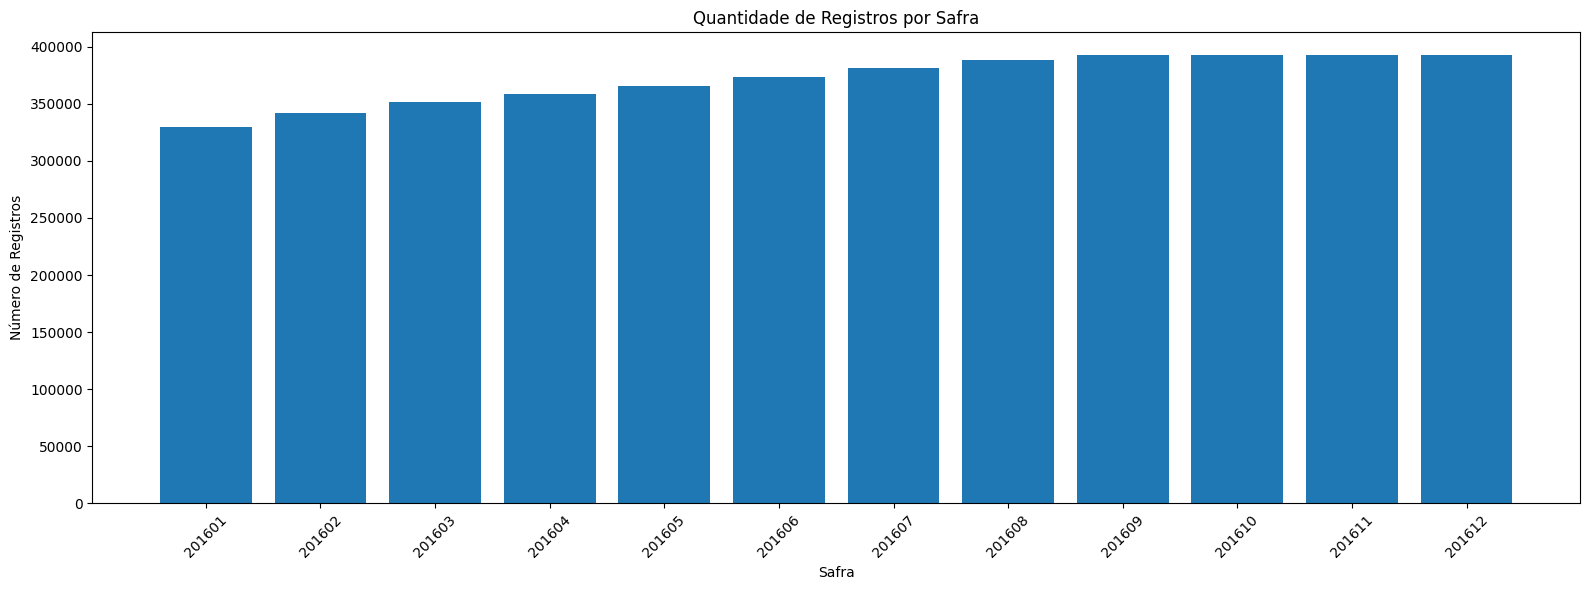

In [ ]:
safra_counts_df = df_members.groupBy("safra").count().orderBy("safra").toPandas()

plt.figure(figsize=(16, 6)) # Aumentando a largura para 14
plt.bar(safra_counts_df["safra"], safra_counts_df["count"])
plt.xlabel("Safra")
plt.ylabel("Número de Registros")
plt.title("Quantidade de Registros por Safra")
plt.xticks(ticks=safra_counts_df["safra"], labels=safra_counts_df["safra"].astype(str), rotation=45)
plt.tight_layout()
plt.show()

###Gênero


In [ ]:
df_members.groupBy("gender").count().orderBy("count", ascending=False).show()

+------+-------+
|gender|  count|
+------+-------+
|  NULL|2050154|
|  male|1261231|
|female|1151282|
+------+-------+



In [ ]:
df_city_churn = df_members.groupBy("gender").agg(
    F.count("*").alias("total"),
    F.sum(F.when(col("is_ativo") == 0, 1).otherwise(0)).alias("inativos")
).withColumn("pct_inativos", F.round(col("inativos") / col("total") * 100, 2))

df_city_churn.orderBy("pct_inativos", ascending=False).show(22)

+------+-------+--------+------------+
|gender|  total|inativos|pct_inativos|
+------+-------+--------+------------+
|female|1151282|  341712|       29.68|
|  male|1261231|  368753|       29.24|
|  NULL|2050154|  481037|       23.46|
+------+-------+--------+------------+



### Idade

In [ ]:
df_members.show(5)

+--------------------+------+----------------------+----+---+------+--------------+--------+
|                msno| safra|registration_init_time|city| bd|gender|registered_via|is_ativo|
+--------------------+------+----------------------+----+---+------+--------------+--------+
|oDModumXtnO/Dk3IZ...|201611|              20150313|   9| 39|female|             9|       0|
|oDNjfZ/YHwyJgtDCA...|201604|              20140204|  13| 30|  male|             9|       1|
|oDd3y3xFYiMuQNrJ+...|201601|              20131013|  13| 24|female|             9|       0|
|oDmGS/XIjIA6XhR6P...|201610|              20151129|   1| 30|  male|             3|       0|
|oDozD3zTCcOFUXLQF...|201602|              20060101|   4| 35|female|             9|       1|
+--------------------+------+----------------------+----+---+------+--------------+--------+
only showing top 5 rows



apesar do nome birthday date (bd) a variavel traz uma informação numérica

In [ ]:
df_members.select("bd").describe().show()

+-------+------------------+
|summary|                bd|
+-------+------------------+
|  count|           4462667|
|   mean| 16.12839833220807|
| stddev|21.725103826844304|
|    min|               -10|
|    max|                99|
+-------+------------------+



In [ ]:
total = df_members.count()

# Idade zero ou negativa
qtd_baixa = df_members.filter(col("bd") <= 0).count()
pct_baixa = qtd_baixa / total * 100

# Idade muito alta
qtd_alta = df_members.filter(col("bd") > 100).count()
pct_alta = qtd_alta / total * 100

print(f"Idades ≤ 0: {qtd_baixa} registros ({pct_baixa:.2f}%)")
print(f"Idades > 100: {qtd_alta} registros ({pct_alta:.2f}%)")


Idades ≤ 0: 2056236 registros (46.08%)
Idades > 100: 2984 registros (0.07%)


In [ ]:
df_safra = df_members.filter(
    (col("safra") == "201612")
)

# Criar coluna com faixa etária
df_safra = df_safra.withColumn(
    "faixa_etaria",
    when(col("bd") < 0, "abaixo de 0")
    .when(col("bd") == 0, "0")
    .when(col("bd") < 10, "0-9")
    .when(col("bd") < 20, "10-19")
    .when(col("bd") < 30, "20-29")
    .when(col("bd") < 40, "30-39")
    .when(col("bd") < 50, "40-49")
    .when(col("bd") < 60, "50-59")
    .when(col("bd") < 70, "60-69")
    .when(col("bd") < 80, " 70-79")
    .when(col("bd") < 90, " 80-89")
    .when(col("bd") < 120, " 90-120")
    .otherwise("a partir de 120")
)

df_safra.groupBy("faixa_etaria").count().orderBy("faixa_etaria").show()


+---------------+------+
|   faixa_etaria| count|
+---------------+------+
|          70-79|   158|
|          80-89|    64|
|         90-120|   285|
|              0|186706|
|            0-9|    89|
|          10-19| 16454|
|          20-29|102660|
|          30-39| 60673|
|          40-49| 18589|
|          50-59|  5987|
|          60-69|  1157|
|a partir de 120|    55|
|    abaixo de 0|    35|
+---------------+------+



Existe um percentual alto de zeros assim como alguns casos negativos, menores de idade e idades muito altas. Sera feita uma avaliação da importância dessa variavel na etapa de featuring

distribuição idade por safra a procura de anomalias

In [ ]:
df_idade_filtrada = df_members.filter(
    (col("bd") >= 10) & (col("bd") <= 120)
).select("safra", "bd")

# Amostra aleatória de 10% da base com seed para reprodutibilidade
df_members_amostra = df_idade_filtrada.sample(withReplacement=False, fraction=0.3, seed=42)


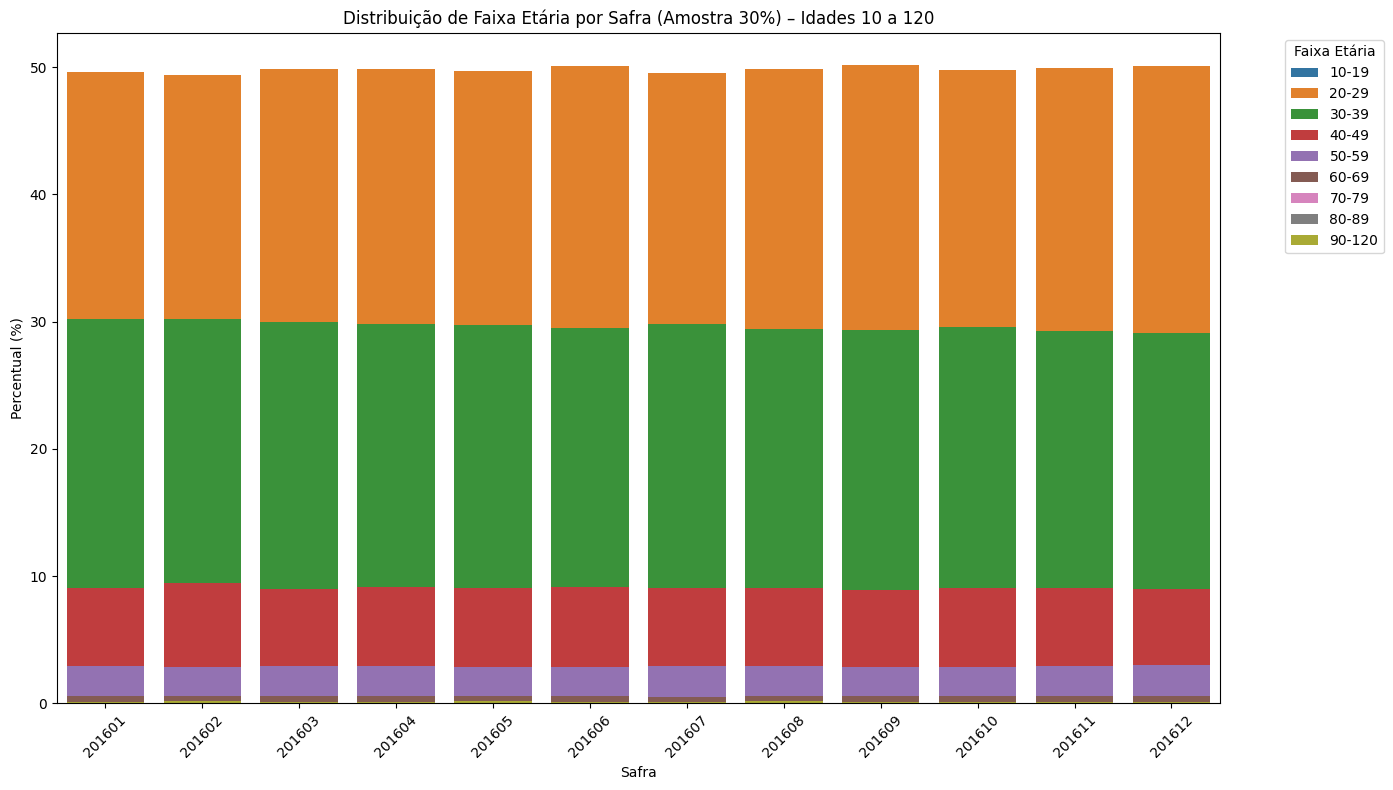

In [ ]:
# Repetir o bucket de faixa etária (caso ainda não tenha sido feito)
from pyspark.sql.functions import when

df_safra_amostra = df_members_amostra.withColumn(
    "faixa_etaria",
    when(col("bd") < 20, "10-19")
    .when(col("bd") < 30, "20-29")
    .when(col("bd") < 40, "30-39")
    .when(col("bd") < 50, "40-49")
    .when(col("bd") < 60, "50-59")
    .when(col("bd") < 70, "60-69")
    .when(col("bd") < 80, "70-79")
    .when(col("bd") < 90, "80-89")
    .otherwise("90-120")
)

# Agrupar faixa x safra
df_safra_faixa = df_safra_amostra.groupBy("safra", "faixa_etaria").count().cache()
# df_safra_faixa.count()

#Converter para Pandas
df_safra_faixa_pd = df_safra_faixa.toPandas()
df_safra_faixa_pd['faixa_etaria'] = df_safra_faixa_pd['faixa_etaria'].str.strip()
df_safra_faixa_pd['percentual'] = df_safra_faixa_pd.groupby('safra')['count'].transform(lambda x: x / x.sum() * 100)

# Ordem correta das faixas
faixa_etaria_order = ["10-19", "20-29", "30-39", "40-49", "50-59", "60-69", "70-79", "80-89", "90-120"]
df_safra_faixa_pd['faixa_etaria'] = pd.Categorical(df_safra_faixa_pd['faixa_etaria'], categories=faixa_etaria_order, ordered=True)

# Plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))
sns.barplot(data=df_safra_faixa_pd, x="safra", y="percentual", hue="faixa_etaria", dodge=False)
plt.xlabel("Safra")
plt.ylabel("Percentual (%)")
plt.title("Distribuição de Faixa Etária por Safra (Amostra 30%) – Idades 10 a 120")
plt.xticks(rotation=45)
plt.legend(title="Faixa Etária", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
#avaliação da proporção de churn na safra de 201612
df_bd_churn = df_safra.groupBy("faixa_etaria").agg(
    F.count("*").alias("total"),
    F.sum(F.when(col("is_ativo") == 0, 1).otherwise(0)).alias("inativos")
).withColumn("pct_inativos", F.round(col("inativos") / col("total") * 100, 2))

df_bd_churn.orderBy("pct_inativos", ascending=False).show(22)

+---------------+------+--------+------------+
|   faixa_etaria| total|inativos|pct_inativos|
+---------------+------+--------+------------+
|         90-120|   285|     144|       50.53|
|            0-9|    89|      43|       48.31|
|          10-19| 16454|    7682|       46.69|
|          70-79|   158|      72|       45.57|
|          60-69|  1157|     442|        38.2|
|          20-29|102660|   37331|       36.36|
|          40-49| 18589|    6539|       35.18|
|    abaixo de 0|    35|      12|       34.29|
|          30-39| 60673|   20522|       33.82|
|          50-59|  5987|    2019|       33.72|
|          80-89|    64|      20|       31.25|
|a partir de 120|    55|      17|       30.91|
|              0|186706|   51263|       27.46|
+---------------+------+--------+------------+



### Cidade

In [ ]:
#contagem distinta

df_members.select("city").distinct().count()

21

In [ ]:
df_members.groupBy("city").count().orderBy("count", ascending=False).show(21)

+----+-------+
|city|  count|
+----+-------+
|   1|1883153|
|  13| 595741|
|   5| 451604|
|   4| 293008|
|  15| 262069|
|  22| 253375|
|   6| 153449|
|  14| 121347|
|  12|  72349|
|   9|  68307|
|  11|  52749|
|   8|  47455|
|  18|  47235|
|  10|  38818|
|  21|  33295|
|  17|  31973|
|   3|  31024|
|   7|  14836|
|  16|   5973|
|  20|   4132|
|  19|    775|
+----+-------+



In [ ]:
df_city_churn = df_members.groupBy("city").agg(
    F.count("*").alias("total"),
    F.sum(F.when(col("is_ativo") == 0, 1).otherwise(0)).alias("inativos")
).withColumn("pct_inativos", F.round(col("inativos") / col("total") * 100, 2))

df_city_churn.orderBy("pct_inativos", ascending=False).show(22)

+----+-------+--------+------------+
|city|  total|inativos|pct_inativos|
+----+-------+--------+------------+
|  19|    775|     266|       34.32|
|   9|  68307|   21816|       31.94|
|  11|  52749|   16527|       31.33|
|  21|  33295|   10153|       30.49|
|   8|  47455|   14374|       30.29|
|  15| 262069|   78569|       29.98|
|  22| 253375|   75643|       29.85|
|   6| 153449|   45800|       29.85|
|  12|  72349|   21599|       29.85|
|  10|  38818|   11536|       29.72|
|  18|  47235|   14012|       29.66|
|  17|  31973|    9232|       28.87|
|  14| 121347|   34367|       28.32|
|   4| 293008|   82909|        28.3|
|  20|   4132|    1165|       28.19|
|   5| 451604|  125489|       27.79|
|   3|  31024|    8620|       27.78|
|   7|  14836|    4012|       27.04|
|  13| 595741|  157468|       26.43|
|  16|   5973|    1520|       25.45|
|   1|1883153|  456425|       24.24|
+----+-------+--------+------------+



### Canal de registro

In [ ]:
df_members.groupBy("registered_via").count().orderBy("count", ascending=False).show()

+--------------+-------+
|registered_via|  count|
+--------------+-------+
|             7|1771293|
|             9|1556129|
|             3| 799549|
|             4| 334681|
|            13|   1015|
+--------------+-------+



Percentual de inativos

In [ ]:
df_city_churn = df_members.groupBy("registered_via").agg(
    F.count("*").alias("total"),
    F.sum(F.when(col("is_ativo") == 0, 1).otherwise(0)).alias("inativos")
).withColumn("pct_inativos", F.round(col("inativos") / col("total") * 100, 2))

df_city_churn.orderBy("pct_inativos", ascending=False).show(22)

+--------------+-------+--------+------------+
|registered_via|  total|inativos|pct_inativos|
+--------------+-------+--------+------------+
|             4| 334681|  178920|       53.46|
|             3| 799549|  316322|       39.56|
|             9|1556129|  461691|       29.67|
|             7|1771293|  234478|       13.24|
|            13|   1015|      91|        8.97|
+--------------+-------+--------+------------+



In [ ]:
#percentual de nulos
total = df_members.count()
nulos = df_members.filter(col("registered_via").isNull()).count()
print(f"Nulos: {nulos} registros ({nulos/total*100:.2f}%)")


Nulos: 0 registros (0.00%)


### Início do registro

In [ ]:
df_members = df_members.withColumn("registration_date", to_date(col("registration_init_time").cast("string"), "yyyyMMdd"))

In [ ]:
df_members.groupBy("registration_date").count().orderBy("registration_date").show(10, truncate=False)


+-----------------+-----+
|registration_date|count|
+-----------------+-----+
|2004-03-26       |504  |
|2004-03-27       |2640 |
|2004-03-28       |1968 |
|2004-03-29       |1464 |
|2004-03-30       |792  |
|2004-03-31       |672  |
|2004-04-01       |348  |
|2004-04-02       |156  |
|2004-04-03       |276  |
|2004-04-04       |168  |
+-----------------+-----+
only showing top 10 rows



In [ ]:
df_members.groupBy(year("registration_date").alias("ano"), month("registration_date").alias("mes")) \
    .count().orderBy("ano", "mes").show()

+----+---+-----+
| ano|mes|count|
+----+---+-----+
|2004|  3| 8040|
|2004|  4| 2640|
|2004|  5|  768|
|2004|  6| 1140|
|2004|  7| 8592|
|2004|  8| 5004|
|2004|  9| 5904|
|2004| 10| 8760|
|2004| 11| 5592|
|2004| 12| 2700|
|2005|  1| 2712|
|2005|  2| 5328|
|2005|  3| 5484|
|2005|  4| 3960|
|2005|  5| 3996|
|2005|  6| 4236|
|2005|  7| 4392|
|2005|  8| 4284|
|2005|  9|10368|
|2005| 10|17220|
+----+---+-----+
only showing top 20 rows



In [ ]:
df_members = df_members.withColumn(
    "safra_date",
    last_day(
        to_date(
            concat_ws("-",
                      col("safra").cast("string").substr(1, 4),
                      col("safra").cast("string").substr(5, 2),
                      lit("01")
            )
        )
    )
)

In [ ]:
df_members = df_members.withColumn(
    "dias_na_base",
    datediff(col("safra_date"), col("registration_date"))
)

In [ ]:
df_members.filter(col("dias_na_base") < 0).count()

0

In [ ]:
df_members = df_members.withColumn(
    "ano_registro",
    year(col("registration_date"))
)

In [ ]:
df_members = df_members.withColumn(
    "mes_registro",
    month(col("registration_date"))
)

In [ ]:
#avaliação da proporção de churn por safra de registro
df_bd_churn = df_members.groupBy(year("registration_date").alias("ano"), month("registration_date").alias("mes")).agg(
    F.count("*").alias("total"),
    F.sum(F.when(col("is_ativo") == 0, 1).otherwise(0)).alias("inativos")
).withColumn("pct_inativos", F.round(col("inativos") / col("total") * 100, 2))

df_bd_churn.orderBy("pct_inativos", ascending=False).show(20)

df_bd_churn.orderBy("pct_inativos", ascending=True).show(20)

+----+---+------+--------+------------+
| ano|mes| total|inativos|pct_inativos|
+----+---+------+--------+------------+
|2015| 12|139656|   53602|       38.38|
|2016|  4| 56745|   21628|       38.11|
|2015|  1| 51336|   18719|       36.46|
|2015|  2| 46992|   16957|       36.08|
|2014| 12| 51324|   17923|       34.92|
|2015|  6| 40692|   13972|       34.34|
|2015|  3| 50532|   17291|       34.22|
|2015|  4| 43764|   14604|       33.37|
|2016|  3|101440|   32020|       31.57|
|2015|  5| 42564|   13361|       31.39|
|2014| 11| 50088|   15682|       31.31|
|2014|  7| 40368|   12555|        31.1|
|2009|  6|  9036|    2799|       30.98|
|2014|  9| 38652|   11912|       30.82|
|2014|  6| 42576|   13082|       30.73|
|2016|  5| 60864|   18499|       30.39|
|2014|  2| 52212|   15775|       30.21|
|2014| 10| 48372|   14591|       30.16|
|2014|  8| 40692|   12255|       30.12|
|2008| 10|  8652|    2603|       30.09|
+----+---+------+--------+------------+
only showing top 20 rows

+----+---+----

In [ ]:
#avaliação da proporção de churn por ano
df_bd_churn = df_members.groupBy("ano_registro").agg(
    F.count("*").alias("total"),
    F.sum(F.when(col("is_ativo") == 0, 1).otherwise(0)).alias("inativos")
).withColumn("pct_inativos", F.round(col("inativos") / col("total") * 100, 2))

df_bd_churn.orderBy("pct_inativos", ascending=False).show(22)

+------------+------+--------+------------+
|ano_registro| total|inativos|pct_inativos|
+------------+------+--------+------------+
|        2014|552108|  166885|       30.23|
|        2008|108336|   30908|       28.53|
|        2009|101004|   28762|       28.48|
|        2015|990672|  279980|       28.26|
|        2016|667967|  183192|       27.43|
|        2007|153708|   40832|       26.56|
|        2013|657816|  170591|       25.93|
|        2012|435972|  109340|       25.08|
|        2004| 49140|   11665|       23.74|
|        2006|102552|   24264|       23.66|
|        2011|344700|   80039|       23.22|
|        2010|214788|   47362|       22.05|
|        2005| 83904|   17682|       21.07|
+------------+------+--------+------------+



In [ ]:
#avaliação da proporção de churn por mes de registro
df_bd_churn = df_members.groupBy("mes_registro").agg(
    F.count("*").alias("total"),
    F.sum(F.when(col("is_ativo") == 0, 1).otherwise(0)).alias("inativos")
).withColumn("pct_inativos", F.round(col("inativos") / col("total") * 100, 2))

df_bd_churn.orderBy("pct_inativos", ascending=False).show(22)

+------------+------+--------+------------+
|mes_registro| total|inativos|pct_inativos|
+------------+------+--------+------------+
|          12|430092|  134359|       31.24|
|           4|298821|   86656|        29.0|
|           2|417885|  117843|        28.2|
|           3|382972|  107531|       28.08|
|           1|465276|  129236|       27.78|
|           6|311529|   83704|       26.87|
|           5|307404|   82289|       26.77|
|          11|380640|  100259|       26.34|
|          10|390588|   96835|       24.79|
|           9|348188|   84855|       24.37|
|           8|371954|   88257|       23.73|
|           7|357318|   79678|        22.3|
+------------+------+--------+------------+



In [ ]:
df_members.select("dias_na_base").describe().show()

+-------+------------------+
|summary|      dias_na_base|
+-------+------------------+
|  count|           4462667|
|   mean|1193.4341607832266|
| stddev| 1062.987119850647|
|    min|                 0|
|    max|              4663|
+-------+------------------+



In [ ]:
df_members = df_members.withColumn(
    "tempo_de_base",
    when(col("dias_na_base") < 30, "<1 mês")
    .when(col("dias_na_base") < 90, "1-3 meses")
    .when(col("dias_na_base") < 180, "3-6 meses")
    .when(col("dias_na_base") < 365, "6-12 meses")
    .otherwise(">1 ano")
)

In [ ]:
#avaliação da proporção de churn por mes de registro
df_bd_churn = df_members.groupBy("tempo_de_base").agg(
    F.count("*").alias("total"),
    F.sum(F.when(col("is_ativo") == 0, 1).otherwise(0)).alias("inativos")
).withColumn("pct_inativos", F.round(col("inativos") / col("total") * 100, 2))

df_bd_churn.orderBy("pct_inativos", ascending=False).show(22)

+-------------+-------+--------+------------+
|tempo_de_base|  total|inativos|pct_inativos|
+-------------+-------+--------+------------+
|   6-12 meses| 644022|  181224|       28.14|
|    3-6 meses| 335516|   93352|       27.82|
|       >1 ano|3223216|  860824|       26.71|
|    1-3 meses| 184220|   41861|       22.72|
|       <1 mês|  75693|   14241|       18.81|
+-------------+-------+--------+------------+



### inativos

In [ ]:
df_churn_safra = df_members.groupBy("safra") \
    .agg(
        count("*").alias("total"),
        F.sum(when(col("is_ativo") == 0, 1).otherwise(0)).alias("inativos")
    ) \
    .withColumn("pct_inativos", F.round(col("inativos") / col("total") * 100, 2)) \
    .orderBy("safra")

In [ ]:
df_churn_safra.show()

+------+------+--------+------------+
| safra| total|inativos|pct_inativos|
+------+------+--------+------------+
|201601|330026|   63604|       19.27|
|201602|341753|   66483|       19.45|
|201603|351897|   90418|       25.69|
|201604|358202|  108705|       30.35|
|201605|365810|  110857|        30.3|
|201606|373577|  120192|       32.17|
|201607|381392|   91121|       23.89|
|201608|388362|   94420|       24.31|
|201609|392912|   95644|       24.34|
|201610|392912|  104992|       26.72|
|201611|392912|  118960|       30.28|
|201612|392912|  126106|        32.1|
+------+------+--------+------------+



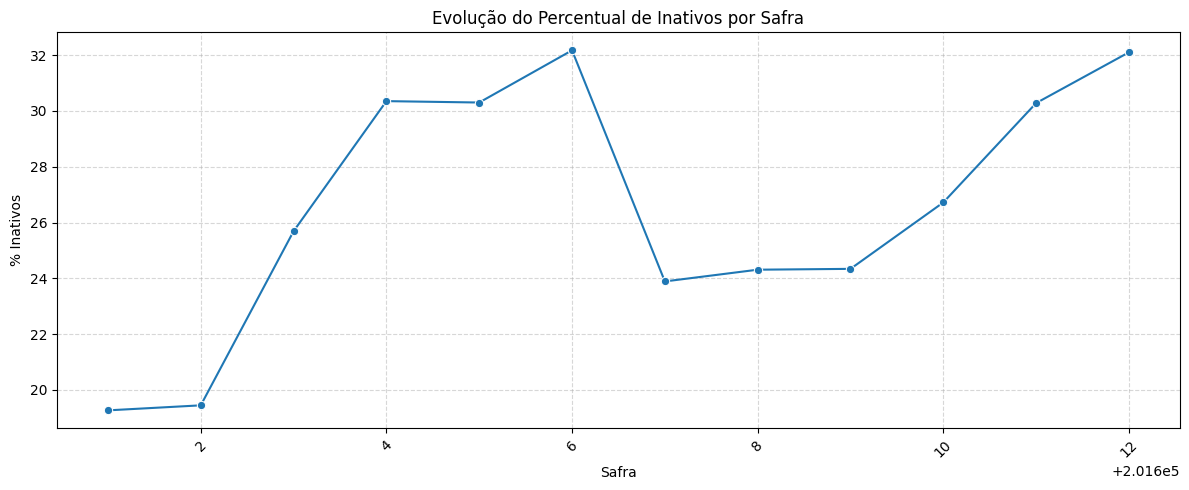

In [ ]:
df_churn_pd = df_churn_safra.toPandas()
plt.figure(figsize=(12, 5))
sns.lineplot(data=df_churn_pd, x="safra", y="pct_inativos", marker="o")
plt.title("Evolução do Percentual de Inativos por Safra")
plt.ylabel("% Inativos")
plt.xlabel("Safra")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

## Base User logs

Variável	Significado
* msno	Identificador único do usuário
* num_25	Número de músicas ou trechos escutados por pelo menos 25% da duração
* num_50	Número de músicas ou trechos escutados por pelo menos 50% da duração
* num_75	Número de músicas ou trechos escutados por pelo menos 75% da duração
* num_985	Número de músicas escutadas por pelo menos 98.5% da duração
* num_100	Número de músicas tocadas até o fim (100%)
* num_unq	Número de músicas únicas escutadas no mês
* total_secs	Total de segundos escutados na plataforma (soma do tempo de escuta no mês)


In [ ]:
df_user_logs = spark.read.parquet(f"{BASE_DIR}/user_logs_filtered.parquet").withColumn("safra", F.col("safra").cast("int"))

In [ ]:
df_user_logs.columns

['msno',
 'safra',
 'num_25',
 'num_50',
 'num_75',
 'num_985',
 'num_100',
 'num_unq',
 'total_secs']

In [ ]:
# Visualizar amostra e schema

df_user_logs.printSchema()
df_user_logs.limit(5).toPandas()

root
 |-- msno: string (nullable = true)
 |-- safra: integer (nullable = true)
 |-- num_25: double (nullable = true)
 |-- num_50: double (nullable = true)
 |-- num_75: double (nullable = true)
 |-- num_985: double (nullable = true)
 |-- num_100: double (nullable = true)
 |-- num_unq: double (nullable = true)
 |-- total_secs: double (nullable = true)



,msno,safra,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,7cIl8CNrBfzHGLakWBM9icFyYlZZqvwED+zVNnIzrtk=,201608,339.0,50.0,35.0,70.0,1129.0,799.0,286647.648
1,7dii1mSxeIoGthqeuLPBzY7385Yduv7PG3mJ2hQrZao=,201611,161.0,17.0,7.0,11.0,377.0,531.0,100983.252
2,7h5lXoC+KDhSby9vC1rhNKJ5foD1S05+nWmLOA/5P14=,201604,43.0,10.0,15.0,21.0,2246.0,2194.0,580164.078
3,7iJ7SHRrY6EE+A1a3a4qRexPAO6s8JD46l5TFIOssqk=,201611,10.0,14.0,13.0,4.0,550.0,546.0,142692.350
4,7jSIA50cu3vzaSO6C4i/k1y8qSVWUt7WndhLLTcOVy4=,201607,64.0,37.0,11.0,19.0,157.0,253.0,48157.154


**Contagem** de linhas e verificação de nulos

In [ ]:
from pyspark.sql.functions import col, isnan, when, count

df_user_logs.count()

6065878

In [ ]:
df_user_logs.select([
    count(when(col(c).isNull() | isnan(c), c)).alias(f"{c}_nulls") for c in df_user_logs.columns
]).toPandas()

,msno_nulls,safra_nulls,num_25_nulls,num_50_nulls,num_75_nulls,num_985_nulls,num_100_nulls,num_unq_nulls,total_secs_nulls
0,0,0,0,0,0,0,0,0,0


In [ ]:
numeric_cols = ['num_25', 'num_50', 'num_75', 'num_985', 'num_100', 'num_unq', 'total_secs']

df_user_logs_new.select(numeric_cols).summary("count", "mean", "min", "stddev", "1%", "5%", "50%", "75%", "90%", "95%", "99%", "max").toPandas()

,summary,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,count,6054426,6054426,6054426,6054426,6054426,6054426,6054426
1,mean,114.47701268460462,28.706510410730928,17.896757512603177,19.942951982566143,548.2052333284773,535.9926427377261,1.856431935233875E10
2,min,0.0,0.0,0.0,0.0,0.0,1.0,0.001
3,stddev,182.06869375188518,41.45161888530622,24.179964549672047,44.61915674831418,769.3199240591468,618.1970747231783,1.3003736317051637E13
4,1%,0.0,0.0,0.0,0.0,0.0,2.0,242.704
5,5%,2.0,0.0,0.0,0.0,7.0,13.0,2641.899
6,50%,58.0,16.0,11.0,11.0,311.0,346.0,85784.65299999999
7,75%,139.0,36.0,24.0,25.0,680.0,715.0,183260.57699999996
8,90%,279.0,69.0,43.0,46.0,1284.0,1245.0,338737.7790000001
9,95%,411.0,99.0,59.0,67.0,1898.0,1709.0,492458.338


* média num100 maior do que das outras. pode ser um problema e

* total secs negativo

* variaveis com caudas longas, como total_secs e num_985


In [ ]:
df_user_logs.select('num_25', 'num_50', 'num_75', 'num_985', 'num_100', 'num_unq', 'total_secs').describe().show()

+-------+------------------+------------------+------------------+-----------------+-----------------+-----------------+--------------------+
|summary|            num_25|            num_50|            num_75|          num_985|          num_100|          num_unq|          total_secs|
+-------+------------------+------------------+------------------+-----------------+-----------------+-----------------+--------------------+
|  count|           6065878|           6065878|           6065878|          6065878|          6065878|          6065878|             6065878|
|   mean|114.65475830539289|28.750192964645844|17.922730394511728|19.96863718657052|549.0703335939166|536.9495044245862|-2.47965810293021...|
| stddev| 182.2599955626133| 41.49873467911155|24.204297951095803|44.61978735995353|769.9333554991316|619.0439870785357|  7.3322300538319E14|
|    min|               0.0|               0.0|               0.0|              0.0|              0.0|              1.0|-2.39807672957245...|
|    m

validação tempo negativo

In [ ]:
from pyspark.sql.functions import col

df_user_logs = df_user_logs.withColumn("total_secs", col("total_secs").cast("double"))
df_user_logs.filter(col("total_secs") < 0).count()  # ver quantos casos errados


11452

In [ ]:
df_user_logs.count()

6065878

In [ ]:
df_user_logs.filter(col("total_secs") < 0).count()/df_user_logs.count()

0.0018879377395984555

In [ ]:
from pyspark.sql.functions import col, when, count

df_user_logs.groupBy("safra").agg(
    (count(when(col("total_secs") < 0, True)) / count("*") * 100).alias("pct_negative_total_secs")
).orderBy("safra").show()

+------+-----------------------+
| safra|pct_negative_total_secs|
+------+-----------------------+
|201501|   5.945833457204864E-4|
|201502|                    0.0|
|201503|   5.711707286424985E-4|
|201504|     0.1934128165253694|
|201505|     0.7614491071721827|
|201506|     0.8856569925395661|
|201507|     1.1333210107998204|
|201508|     1.1457561133047902|
|201509|      1.132385146913862|
|201510|     0.4329204554915219|
|201511|    0.07588061449985356|
|201512|    0.03843765707696402|
|201601|   0.019972278477473265|
|201602|    0.01005056205835511|
|201603|   0.011717524502855674|
|201604|   0.005304758368256326|
|201605|                    0.0|
|201606|                    0.0|
|201607|                    0.0|
|201608|                    0.0|
+------+-----------------------+
only showing top 20 rows



Sera realizada a remoção de negativos

In [ ]:
df_user_logs_new = df_user_logs.filter(col("total_secs") >= 0)

In [ ]:
numeric_cols = ['num_25', 'num_50', 'num_75', 'num_985', 'num_100', 'num_unq', 'total_secs']

df_user_logs_new.select(numeric_cols).summary("count", "mean", "min", "max", "stddev").toPandas()

,summary,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,count,6054426,6054426,6054426,6054426,6054426,6054426,6054426
1,mean,114.47701268460462,28.706510410730928,17.896757512603177,19.942951982566143,548.2052333284773,535.9926427377261,1.856431935233875E10
2,min,0.0,0.0,0.0,0.0,0.0,1.0,0.001
3,max,75644.0,5002.0,2919.0,37698.0,74796.0,22381.0,9.223372037005636E15
4,stddev,182.06869375188518,41.45161888530622,24.179964549672047,44.61915674831418,769.3199240591468,618.1970747231783,1.3003736317051637E13


casos logicamente inconsistentes

In [ ]:
df_user_logs_new.filter(col("num_100") > col("num_25")).count()

5459261

In [ ]:
df_user_logs_new.filter(col("num_100") > col("num_25")).count()/df_user_logs_new.count()

0.9016975349934081

Por isso:
* Não é um erro num_100 > num_25.


* Só significa que o cálculo foi feito separadamente, não em cascata.

correlação entre counas

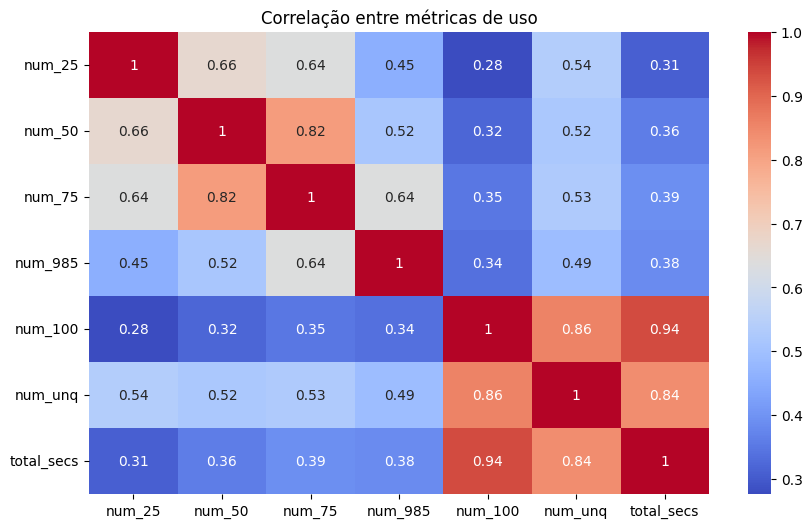

In [ ]:
sample_df = df_user_logs_new.select(numeric_cols).sample(fraction=0.01).toPandas()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(sample_df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Correlação entre métricas de uso")
plt.show()

num_100, num_unq e total_secs são fortes candidatos a features finais de engajamento.

Variáveis num_25, num_50, num_75 ainda ajudam, mas são menos diretamente ligadas ao volume real de uso.

num_985 parece "intermediária" — boa para capturar nuance.

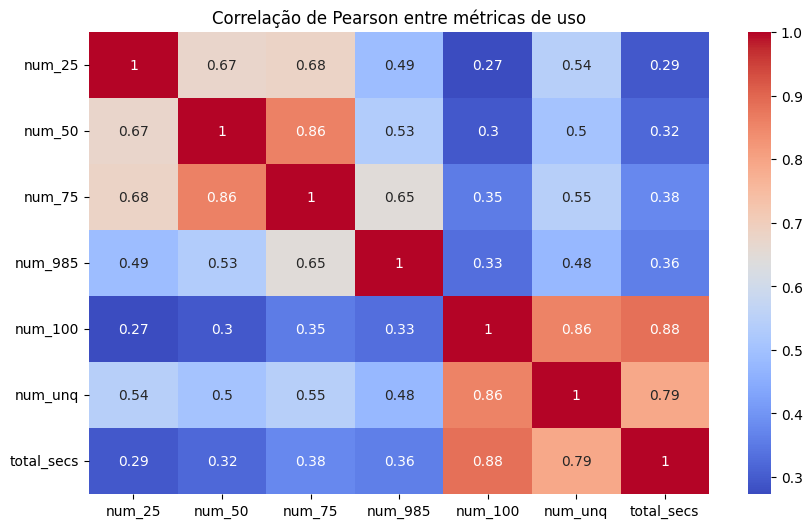

In [ ]:
sample_df = df_user_logs_new.select(numeric_cols).sample(fraction=0.01).toPandas()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(sample_df.corr(method='pearson', numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Correlação de Pearson entre métricas de uso")
plt.show()

In [ ]:
df_user_logs.select("msno").distinct().count()

from pyspark.sql.functions import countDistinct

df_user_logs_new.groupBy("msno").count().selectExpr("percentile(count, array(0.5)) as med_linhas_por_usuario").show()

+----------------------+
|med_linhas_por_usuario|
+----------------------+
|                [16.0]|
+----------------------+



In [ ]:
df_user_logs_new.groupBy("safra").count().orderBy("safra").show(30)

+------+------+
| safra| count|
+------+------+
|201501|168184|
|201502|170676|
|201503|175078|
|201504|179062|
|201505|181287|
|201506|183869|
|201507|187209|
|201508|196025|
|201509|203605|
|201510|215270|
|201511|225183|
|201512|236656|
|201601|250297|
|201602|258666|
|201603|264530|
|201604|263900|
|201605|266599|
|201606|271818|
|201607|277254|
|201608|280375|
|201609|285955|
|201610|273595|
|201611|266828|
|201612|262836|
|201701|258948|
|201702|250721|
+------+------+



## Base Transactions

Coluna	Descrição
* msno	Identificador do usuário
* payment_method_id	ID do método de pagamento
* payment_plan_days	Duração do plano em dias (ex: 30, 365)
* plan_list_price	Preço "cheio" do plano
* actual_amount_paid	Valor realmente pago (com desconto ou não)
* is_auto_renew	Flag de renovação automática
* transaction_date	Data da transação
* membership_expire_date	Data de expiração da assinatura
* is_cancel	Cancelamento (1 = sim)

In [ ]:
df_transactions = spark.read.parquet(f"{BASE_DIR}/transactions_filtered.parquet").withColumn("safra", F.col("safra").cast("int"))

In [ ]:
df_transactions.printSchema()
df_transactions.limit(5).toPandas()

root
 |-- msno: string (nullable = true)
 |-- payment_method_id: string (nullable = true)
 |-- payment_plan_days: string (nullable = true)
 |-- plan_list_price: string (nullable = true)
 |-- actual_amount_paid: string (nullable = true)
 |-- is_auto_renew: string (nullable = true)
 |-- transaction_date: string (nullable = true)
 |-- membership_expire_date: string (nullable = true)
 |-- is_cancel: string (nullable = true)
 |-- safra: integer (nullable = true)



,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,safra
0,hG6PmzgDxJLQHvGFCgSwibqYBe+Ghgc9u/Csr80jCRA=,35,7,0,0,0,20161030,20161106,0,201610
1,hG6qS3UsUsqCAj/ij5M9LqPykJ37hovcyT7ztW6B4KI=,41,30,99,99,1,20161127,20161227,0,201611
2,hGA/Ou0131a1RmSkZXqO5nTd/dD/Q4hSrCIWg15QpZk=,39,31,149,149,1,20150331,20150518,0,201503
3,hGA/Ou0131a1RmSkZXqO5nTd/dD/Q4hSrCIWg15QpZk=,39,30,149,149,1,20170131,20170318,0,201701
4,hGH6kTNuqMSpfUWqruP35YEfkelmMan2feqOPfIn4+E=,32,180,536,536,0,20160730,20170201,0,201607


verificar nulos

In [ ]:
from pyspark.sql.functions import col, count, when, isnan

df_transactions.select([
    count(when(col(c).isNull() | isnan(c), c)).alias(c + "_nulls") for c in df_transactions.columns
]).toPandas()

,msno_nulls,payment_method_id_nulls,payment_plan_days_nulls,plan_list_price_nulls,actual_amount_paid_nulls,is_auto_renew_nulls,transaction_date_nulls,membership_expire_date_nulls,is_cancel_nulls,safra_nulls
0,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_transactions.select(
    "payment_plan_days", "plan_list_price", "actual_amount_paid"
).summary("count", "mean", "min", "stddev", "1%", "5%", "50%", "75%", "90%", "95%", "99%", "max").toPandas()

,summary,payment_plan_days,plan_list_price,actual_amount_paid
0,count,5038181,5038181,5038181
1,mean,32.40048759661473,146.19680237768353,151.64621616412748
2,min,0,0,0
3,stddev,33.286655091301725,143.08842964476722,143.21873811751422
4,1%,0.0,0.0,0.0
5,5%,7.0,0.0,99.0
6,50%,30.0,149.0,149.0
7,75%,30.0,149.0,149.0
8,90%,30.0,149.0,149.0
9,95%,31.0,180.0,180.0


max 99 acima da média - possivel erro

In [ ]:
from pyspark.sql.functions import max

df_transactions.select(
    max("plan_list_price"), max("actual_amount_paid")
).show()

+--------------------+-----------------------+
|max(plan_list_price)|max(actual_amount_paid)|
+--------------------+-----------------------+
|                  99|                     99|
+--------------------+-----------------------+



In [ ]:
from pyspark.sql.functions import col
df_transactions = df_transactions.withColumn("payment_plan_days", col("payment_plan_days").cast("double"))
df_transactions = df_transactions.withColumn("plan_list_price", col("plan_list_price").cast("double"))
df_transactions = df_transactions.withColumn("actual_amount_paid", col("actual_amount_paid").cast("double"))


In [ ]:
df_transactions.select(
    "payment_plan_days", "plan_list_price", "actual_amount_paid"
).summary("count", "mean", "min", "stddev", "1%", "5%", "50%", "75%", "90%", "95%", "99%", "max").toPandas()

,summary,payment_plan_days,plan_list_price,actual_amount_paid
0,count,5038181,5038181,5038181
1,mean,32.40048759661473,146.19680237768353,151.64621616412748
2,min,0.0,0.0,0.0
3,stddev,33.286655091301725,143.08842964476722,143.21873811751422
4,1%,0.0,0.0,0.0
5,5%,7.0,0.0,99.0
6,50%,30.0,149.0,149.0
7,75%,30.0,149.0,149.0
8,90%,30.0,149.0,149.0
9,95%,31.0,180.0,180.0


distribuição  valores planos

In [ ]:
df_transactions.groupBy("plan_list_price").count().orderBy("count", ascending = False).show(50)

+---------------+-------+
|plan_list_price|  count|
+---------------+-------+
|          149.0|3043110|
|           99.0|1058284|
|          129.0| 295594|
|            0.0| 262959|
|          180.0| 172922|
|          150.0|  92377|
|          894.0|  30321|
|         1788.0|  23623|
|          100.0|  12618|
|          536.0|  12417|
|          119.0|   8197|
|          480.0|   6354|
|         1599.0|   3472|
|          477.0|   2857|
|          799.0|   1795|
|          930.0|   1517|
|          298.0|   1505|
|         1200.0|   1462|
|          300.0|   1385|
|          120.0|    959|
|           35.0|    902|
|          134.0|    839|
|          447.0|    831|
|          450.0|    401|
|          500.0|    324|
|          699.0|    280|
|         1000.0|    190|
|           50.0|    186|
|          350.0|    141|
|          131.0|     82|
|          400.0|     73|
|         2000.0|     40|
|          143.0|     36|
|          105.0|     30|
|           70.0|     24|
|         11

será feito um teste de feature considerando faixas de preço

avaliação descontos

In [ ]:
from pyspark.sql.functions import expr

df_transactions = df_transactions.withColumn("teve_desconto", expr("actual_amount_paid < plan_list_price"))
df_transactions.groupBy("teve_desconto").count().show()

+-------------+-------+
|teve_desconto|  count|
+-------------+-------+
|         true| 102621|
|        false|4935560|
+-------------+-------+



imensa maioria dos usuários não teve desocnto mas é possíve usar essa informação como feature

pagamento a mais?

In [ ]:
df_transactions.filter(col("actual_amount_paid") > col("plan_list_price")).count()

209959

In [ ]:
df_transactions.filter(col("actual_amount_paid") > col("plan_list_price")).count()/df_transactions.count()

0.04167357226745129

Avaliação ids pagamento

In [ ]:
df_transactions.groupBy("payment_method_id").count().orderBy("count", ascending=False).show()
df_transactions.groupBy("payment_plan_days").count().orderBy("payment_plan_days").show()

+-----------------+-------+
|payment_method_id|  count|
+-----------------+-------+
|               41|2509635|
|               40| 604659|
|               38| 421677|
|               39| 399560|
|               37| 278904|
|               36| 218262|
|               34| 194276|
|               33| 108561|
|               31|  69947|
|               32|  41686|
|               35|  41612|
|               30|  25646|
|               28|  24621|
|               29|  24068|
|               27|  16180|
|               23|  11121|
|               20|   7923|
|               19|   6971|
|               22|   5781|
|               21|   5318|
+-----------------+-------+
only showing top 20 rows

+-----------------+-------+
|payment_plan_days|  count|
+-----------------+-------+
|              0.0| 210560|
|              1.0|    660|
|              2.0|      8|
|              3.0|      4|
|              7.0|  46147|
|             10.0|   4673|
|             14.0|    684|
|             15.0|   

In [ ]:
from pyspark.sql.functions import expr

df_transactions = df_transactions.withColumn(
    "tem_desconto", expr("actual_amount_paid < plan_list_price")
)
df_transactions.groupBy("tem_desconto").count().show()

+------------+-------+
|tem_desconto|  count|
+------------+-------+
|        true| 102621|
|       false|4935560|
+------------+-------+



In [ ]:
from pyspark.sql.functions import to_date

df_transactions = df_transactions.withColumn("transaction_date", to_date(col("transaction_date").cast("string"), "yyyyMMdd"))
df_transactions = df_transactions.withColumn("membership_expire_date", to_date(col("membership_expire_date").cast("string"), "yyyyMMdd"))

In [ ]:
from pyspark.sql.functions import date_format

df_transactions.groupBy(date_format("transaction_date", "yyyyMM").alias("safra")).count().orderBy("safra").show()

+------+------+
| safra| count|
+------+------+
|201501|123719|
|201502|125450|
|201503|146571|
|201504|132054|
|201505|134504|
|201506|154674|
|201507|161232|
|201508|170012|
|201509|172820|
|201510|161728|
|201511|196924|
|201512|209279|
|201601|217854|
|201602|203095|
|201603|201105|
|201604|201040|
|201605|204391|
|201606|210325|
|201607|243788|
|201608|255375|
+------+------+
only showing top 20 rows



## Join

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
BASE_DIR = "/content/drive/MyDrive/DataMaster/dm"
df_transactions  = spark.read.parquet(f"{BASE_DIR}/transactions_filtered.parquet").withColumn("safra", F.col("safra").cast("int"))
df_members  = spark.read.parquet(f"{BASE_DIR}/members_filtered.parquet").withColumn("safra", F.col("safra").cast("int"))
df_user_logs  = spark.read.parquet(f"{BASE_DIR}/user_logs_filtered.parquet").withColumn("safra", F.col("safra").cast("int"))
df_target   = spark.read.parquet(f"{BASE_DIR}/df_target_sample.parquet").withColumn("safra", F.col("safra").cast("int")).withColumn("target", F.col("target").cast("int"))

In [38]:
# Realizar os joins
df_joined = df_target.join(df_transactions, on=["msno", "safra"], how="left")\
  .join(df_members, on=["msno", "safra"], how="left")\
  .join(df_user_logs, on=["msno", "safra"], how="left")

# Exibir o schema e uma amostra do DataFrame resultante
df_joined.printSchema()
df_joined.show(5)



root
 |-- msno: string (nullable = true)
 |-- safra: integer (nullable = true)
 |-- target: integer (nullable = true)
 |-- payment_method_id: string (nullable = true)
 |-- payment_plan_days: string (nullable = true)
 |-- plan_list_price: string (nullable = true)
 |-- actual_amount_paid: string (nullable = true)
 |-- is_auto_renew: string (nullable = true)
 |-- transaction_date: string (nullable = true)
 |-- membership_expire_date: string (nullable = true)
 |-- is_cancel: string (nullable = true)
 |-- registration_init_time: string (nullable = true)
 |-- city: string (nullable = true)
 |-- bd: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- registered_via: string (nullable = true)
 |-- is_ativo: integer (nullable = true)
 |-- num_25: double (nullable = true)
 |-- num_50: double (nullable = true)
 |-- num_75: double (nullable = true)
 |-- num_985: double (nullable = true)
 |-- num_100: double (nullable = true)
 |-- num_unq: double (nullable = true)
 |-- total_secs: do

In [39]:
import os
from google.colab import drive

# === Define the output path ===
output_dir = "/content/drive/MyDrive/DataMaster/dm"
os.makedirs(output_dir, exist_ok=True)  # create the folder if it doesn't exist

# === Check if the path is accessible and writable ===
if os.access(output_dir, os.W_OK):
    print(f"📂 Output folder confirmed: {output_dir}")
else:
    raise PermissionError(f"❌ No write permission in {output_dir}. Check if the Drive is mounted correctly.")

# === Final file path ===
output_path = os.path.join(output_dir, "df_dm_join.parquet")

# === Save safely ===
try:
    df_joined.write.mode("overwrite").parquet(output_path)
    print(f"✅ DataFrame saved successfully to:\n   {output_path}")
except Exception as e:
    print(f"❌ Error saving the file: {e}")

# === (Optional) Verify that the file actually exists on Drive ===
if os.path.exists(output_path):
    print("🟢 Verification OK: the file is saved on Drive.")
else:
    print("⚠️ Warning: the file was not found after saving — check if the Drive is mounted.")

📂 Output folder confirmed: /content/drive/MyDrive/DataMaster/dm
✅ DataFrame saved successfully to:
   /content/drive/MyDrive/DataMaster/dm/df_dm_join.parquet
🟢 Verification OK: the file is saved on Drive.


In [40]:
# Read the joined DataFrame from Google Drive
input_path = "/content/drive/MyDrive/DataMaster/dm/df_dm_join.parquet"

# Read the DataFrame in Parquet format
df = spark.read.parquet(input_path)

print(f"DataFrame lido de: {input_path}")
df.show(5)

DataFrame lido de: /content/drive/MyDrive/DataMaster/dm/df_dm_join.parquet
+--------------------+------+------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+----------------------+----+---+------+--------------+--------+------+------+------+-------+-------+-------+------------------+
|                msno| safra|target|payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|registration_init_time|city| bd|gender|registered_via|is_ativo|num_25|num_50|num_75|num_985|num_100|num_unq|        total_secs|
+--------------------+------+------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+----------------------+----+---+------+--------------+--------+------+------+------+-------+-------+-------+------------------+
|++/UDNo9DLrxT8QVG...|201602

In [41]:
from pyspark.sql.functions import countDistinct, count

df.groupBy("safra").agg(
    countDistinct("msno").alias("unique_msno_count"),
    count("*").alias("total_records_count")
).orderBy("safra").show()

+------+-----------------+-------------------+
| safra|unique_msno_count|total_records_count|
+------+-----------------+-------------------+
|201601|           266422|             266422|
|201602|           275270|             275270|
|201603|           261479|             261479|
|201604|           249497|             249497|
|201605|           254953|             254953|
|201606|           253385|             253385|
|201607|           290271|             290271|
|201608|           293942|             293942|
|201609|           297268|             297268|
+------+-----------------+-------------------+



Considerações sobre as safras:
* 201601, 201602, 201603 - valores de taxa de churn muito distintos  - serão desconsiderados
* 201604, 201605, 201606, 201607, 201608 - teste/treino
* 201609 - out of time
* 201610, 201611, 201612 - não tem target maturada para avaliação

In [42]:
safras_treino_teste = [201604, 201605, 201606, 201607, 201608]
safra_oot = [201609]

In [43]:
df.columns

['msno',
 'safra',
 'target',
 'payment_method_id',
 'payment_plan_days',
 'plan_list_price',
 'actual_amount_paid',
 'is_auto_renew',
 'transaction_date',
 'membership_expire_date',
 'is_cancel',
 'registration_init_time',
 'city',
 'bd',
 'gender',
 'registered_via',
 'is_ativo',
 'num_25',
 'num_50',
 'num_75',
 'num_985',
 'num_100',
 'num_unq',
 'total_secs']

In [44]:
from pyspark.sql.functions import col

# Filtra o DataFrame para incluir apenas as safras de treino/teste especificadas
# Mantemos a variável original df_treino_teste para referência, se necessário,
# mas a divisão será feita diretamente no df filtrado por safras_treino_teste e is_ativo=1.
df_para_split = df.filter(col("safra").isin(safras_treino_teste)).filter(col("is_ativo") == 1)

# Define as proporções para a divisão aleatória
treino_ratio = 0.7
teste_ratio = 0.2
validacao_ratio = 0.1
seed = 42

# Realiza a divisão aleatória nos dados de treino/teste/validação
df_treino, df_teste, df_validacao = df_para_split.randomSplit([treino_ratio, teste_ratio, validacao_ratio], seed=seed)

# Cria o conjunto Out-of-Time (OOT) filtrando pela safra OOT e is_ativo=1
df_oot = df.filter(col("safra").isin(safra_oot)).filter(col("is_ativo") == 1)


# Exibe as contagens para cada conjunto para verificar a divisão
print("Contagem do conjunto de treino:")
print(df_treino.count())

print("Contagem do conjunto de teste:")
print(df_teste.count())

print("Contagem do conjunto de validação:")
print(df_validacao.count())

print("Contagem do conjunto Out-of-Time (OOT):")
print(df_oot.count())

# Exibe as contagens por safra para ver a distribuição
print("Contagens do conjunto de treino por safra:")
df_treino.groupBy("safra").count().orderBy("safra").show()

print("Contagens do conjunto de teste por safra:")
df_teste.groupBy("safra").count().orderBy("safra").show()

print("Contagens do conjunto de validação por safra:")
df_validacao.groupBy("safra").count().orderBy("safra").show()

print("Contagens do conjunto Out-of-Time (OOT) por safra:")
df_oot.groupBy("safra").count().orderBy("safra").show()

Contagem do conjunto de treino:
939761
Contagem do conjunto de teste:
268122
Contagem do conjunto de validação:
134165
Contagem do conjunto Out-of-Time (OOT):
297268
Contagens do conjunto de treino por safra:
+------+------+
| safra| count|
+------+------+
|201604|174587|
|201605|178512|
|201606|177592|
|201607|203044|
|201608|206026|
+------+------+

Contagens do conjunto de teste por safra:
+------+-----+
| safra|count|
+------+-----+
|201604|49761|
|201605|51269|
|201606|50314|
|201607|58221|
|201608|58557|
+------+-----+

Contagens do conjunto de validação por safra:
+------+-----+
| safra|count|
+------+-----+
|201604|25149|
|201605|25172|
|201606|25479|
|201607|29006|
|201608|29359|
+------+-----+

Contagens do conjunto Out-of-Time (OOT) por safra:
+------+------+
| safra| count|
+------+------+
|201609|297268|
+------+------+



Taxa de Churn em df_treino: 11.48% (Total: 939761, Churn: 107857)
Taxa de Churn em df_teste: 11.50% (Total: 268122, Churn: 30838)
Taxa de Churn em df_validacao: 11.50% (Total: 134165, Churn: 15435)
Taxa de Churn em df_oot: 13.00% (Total: 297268, Churn: 38643)


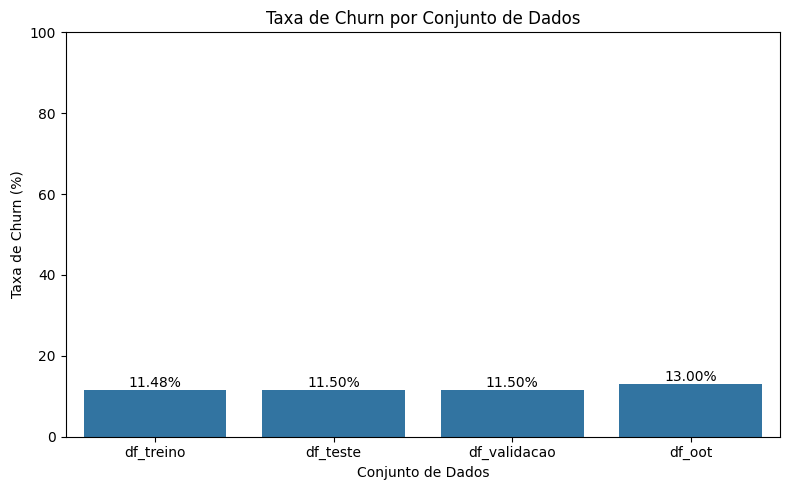

In [46]:
from pyspark.sql.functions import col, count, sum

# Função para calcular a taxa de churn
def calculate_churn_rate(df, name):
    total_count = df.count()
    target_one_count = df.filter(col("target") == 1).count()
    churn_rate = (target_one_count / total_count) * 100 if total_count > 0 else 0
    print(f"Taxa de Churn em {name}: {churn_rate:.2f}% (Total: {total_count}, Churn: {target_one_count})")
    return name, churn_rate

# Calcular a taxa de churn para cada DataFrame
churn_rates = []
churn_rates.append(calculate_churn_rate(df_treino, "df_treino"))
churn_rates.append(calculate_churn_rate(df_teste, "df_teste"))
churn_rates.append(calculate_churn_rate(df_validacao, "df_validacao"))
churn_rates.append(calculate_churn_rate(df_oot, "df_oot"))

# Preparar dados para plotagem
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_churn_rates_pd = pd.DataFrame(churn_rates, columns=["Dataset", "Churn Rate (%)"])

# Plotar os resultados
plt.figure(figsize=(8, 5))
ax = sns.barplot(x="Dataset", y="Churn Rate (%)", data=df_churn_rates_pd)
plt.title("Taxa de Churn por Conjunto de Dados")
plt.ylabel("Taxa de Churn (%)")
plt.xlabel("Conjunto de Dados")
plt.ylim(0, 100)

# Adicionar rótulos nas barras
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f%%')

plt.tight_layout()
plt.show()

In [47]:
import os
from google.colab import drive

# Define o diretório base no Google Drive
output_dir = "/content/drive/MyDrive/DataMaster/dm"
os.makedirs(output_dir, exist_ok=True)  # Cria a pasta se não existir

# Função auxiliar para salvar DataFrames
def save_dataframe(df, name):
    path = os.path.join(output_dir, f"{name}.parquet")
    try:
        df.write.mode("overwrite").parquet(path)
        print(f"✅ DataFrame '{name}' salvo com sucesso em:\n   {path}")
    except Exception as e:
        print(f"❌ Erro ao salvar o DataFrame '{name}': {e}")

# Salva os DataFrames
save_dataframe(df_treino, "df_treino")
save_dataframe(df_teste, "df_teste")
save_dataframe(df_validacao, "df_validacao")
save_dataframe(df_oot, "df_oot")

✅ DataFrame 'df_treino' salvo com sucesso em:
   /content/drive/MyDrive/DataMaster/dm/df_treino.parquet
✅ DataFrame 'df_teste' salvo com sucesso em:
   /content/drive/MyDrive/DataMaster/dm/df_teste.parquet
✅ DataFrame 'df_validacao' salvo com sucesso em:
   /content/drive/MyDrive/DataMaster/dm/df_validacao.parquet
✅ DataFrame 'df_oot' salvo com sucesso em:
   /content/drive/MyDrive/DataMaster/dm/df_oot.parquet


## Exploratória base unida

a partir da amostra de treino será realizada a continnuação da análise exploratória

In [9]:
# Read the training DataFrame from Google Drive
input_path_treino = "/content/drive/MyDrive/DataMaster/dm_split/df_treino.parquet"

# Read the DataFrame in Parquet format
df_treino = spark.read.parquet(input_path_treino)

print(f"DataFrame de treino lido de: {input_path_treino}")
df_treino.show(5)

DataFrame de treino lido de: /content/drive/MyDrive/DataMaster/dm_split/df_treino.parquet
+--------------------+------+------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+----------------------+----+---+------+--------------+--------+------+------+------+-------+-------+-------+------------------+
|                msno| safra|target|payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|registration_init_time|city| bd|gender|registered_via|is_ativo|num_25|num_50|num_75|num_985|num_100|num_unq|        total_secs|
+--------------------+------+------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+----------------------+----+---+------+--------------+--------+------+------+------+-------+-------+-------+------------------+
|++/UDNo9DLrx

In [10]:
df_treino.columns

['msno',
 'safra',
 'target',
 'payment_method_id',
 'payment_plan_days',
 'plan_list_price',
 'actual_amount_paid',
 'is_auto_renew',
 'transaction_date',
 'membership_expire_date',
 'is_cancel',
 'registration_init_time',
 'city',
 'bd',
 'gender',
 'registered_via',
 'is_ativo',
 'num_25',
 'num_50',
 'num_75',
 'num_985',
 'num_100',
 'num_unq',
 'total_secs']

A avaliação de nulos será refeita uma vez que a união das bases junto a base_members pode trazer nulos. A partir dessa avaliação será determinados o tratamento adequado aos nulos.

In [11]:
from pyspark.sql.functions import col, sum as spark_sum, when, lit

# Get the total number of rows in the DataFrame
total_rows = df_treino.count()

# Create a list of tuples, where each tuple is (column_name, null_percentage)
null_percentages_list = []
for c in df_treino.columns:
    null_count = df_treino.filter(col(c).isNull()).count()
    null_pct = (null_count / total_rows) * 100 if total_rows > 0 else 0
    null_percentages_list.append((c, null_pct))

# Create a new DataFrame from the list
# If the list is empty (e.g., empty DataFrame), create an empty DataFrame with schema
if null_percentages_list:
    from pyspark.sql import Row
    null_percentages_df = spark.createDataFrame([Row(Variable=var, Null_Percentage=pct) for var, pct in null_percentages_list])
else:
    from pyspark.sql.types import StructType, StructField, StringType, DoubleType
    schema = StructType([StructField("Variable", StringType(), True), StructField("Null_Percentage", DoubleType(), True)])
    null_percentages_df = spark.createDataFrame([], schema)


# Show the results
null_percentages_df.orderBy("Null_Percentage", ascending=False).show(n=null_percentages_df.count(), truncate=False)

+----------------------+------------------+
|Variable              |Null_Percentage   |
+----------------------+------------------+
|gender                |48.4912362094797  |
|payment_method_id     |16.910731919095614|
|membership_expire_date|16.910731919095614|
|actual_amount_paid    |16.910731919095614|
|is_cancel             |16.910731919095614|
|payment_plan_days     |16.910731919095614|
|is_auto_renew         |16.910731919095614|
|plan_list_price       |16.910731919095614|
|transaction_date      |16.910731919095614|
|num_100               |10.475900640152547|
|num_25                |10.475900640152547|
|num_unq               |10.475900640152547|
|num_50                |10.475900640152547|
|total_secs            |10.475900640152547|
|num_75                |10.475900640152547|
|num_985               |10.475900640152547|
|city                  |0.0               |
|registration_init_time|0.0               |
|bd                    |0.0               |
|registered_via        |0.0     

a variavel is_ativo foi considerada na definição do churn, e a fim de evitar leakage não será utilizada para treino

In [12]:
variaveis_quali = [
 'payment_method_id',
 'is_auto_renew',
 'is_cancel',
 'city',
 'gender',
 'registered_via']

In [13]:
from pyspark.sql.functions import to_date, last_day, concat_ws, lit, datediff, col

def add_date_features(df):
    """
    Adiciona features de tempo (diferença de dias) a partir das colunas de data.

    Args:
        df (DataFrame): O DataFrame de entrada com colunas de data (string yyyyMMdd).

    Returns:
        DataFrame: O DataFrame com as novas features de tempo adicionadas.
    """
    # Ensure date columns are in DateType format
    df = df.withColumn("transaction_date", to_date(col("transaction_date").cast("string"), "yyyyMMdd"))
    df = df.withColumn("membership_expire_date", to_date(col("membership_expire_date").cast("string"), "yyyyMMdd"))
    df = df.withColumn("registration_init_time", to_date(col("registration_init_time").cast("string"), "yyyyMMdd"))

    # Calculate the last day of the safra month
    df = df.withColumn(
        "safra_end_date",
        last_day(
            to_date(
                concat_ws("-",
                          col("safra").cast("string").substr(1, 4),
                          col("safra").cast("string").substr(5, 2),
                          lit("01")
                )
            )
        )
    )

    # Calculate the difference in days
    df = df.withColumn(
        "days_since_transaction",
        datediff(col("safra_end_date"), col("transaction_date"))
    )

    df = df.withColumn(
        "days_until_membership_expire",
        datediff(col("membership_expire_date"), col("safra_end_date"))
    )

    df = df.withColumn(
        "days_since_registration",
        datediff(col("safra_end_date"), col("registration_init_time"))
    )

    # Drop the auxiliary safra_end_date column
    df = df.drop("safra_end_date")

    return df

In [14]:
df_treino = add_date_features(df_treino)

In [15]:
df_treino.show()

+--------------------+------+------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+----------------------+----+---+------+--------------+--------+------+------+------+-------+-------+-------+------------------+----------------------+----------------------------+-----------------------+
|                msno| safra|target|payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|registration_init_time|city| bd|gender|registered_via|is_ativo|num_25|num_50|num_75|num_985|num_100|num_unq|        total_secs|days_since_transaction|days_until_membership_expire|days_since_registration|
+--------------------+------+------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+----------------------+----+---+------+--------------+--------+------+------+--

In [16]:
variaveis_quanti = [
 'payment_plan_days',
 'bd',
 'plan_list_price',
 'actual_amount_paid',
 'days_since_transaction',
 'days_until_membership_expire',
 'days_since_registration',
 'num_25',
 'num_50',
 'num_75',
 'num_985',
 'num_100',
 'num_unq',
 'total_secs']

### análise quantitativas

In [17]:
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType

# List of quantitative columns that might need casting (excluding those already handled by date features)
cols_to_cast_numeric = [
    'payment_plan_days',
    'plan_list_price',
    'actual_amount_paid',
    'bd' # Assuming 'bd' should also be numeric for analysis
    # num_25, num_50, etc. are already double according to schema
]

# Cast the specified columns to DoubleType
for c in cols_to_cast_numeric:
    if c in df_treino.columns: # Check if column exists
        # Cast only if the column is not already numeric
        if dict(df_treino.dtypes)[c] not in ['double', 'float', 'int', 'long', 'decimal']:
             df_treino = df_treino.withColumn(c, col(c).cast(DoubleType()))
             print(f"Cast column '{c}' to DoubleType")
        else:
             print(f"Column '{c}' is already numeric.")
    else:
        print(f"Column '{c}' not found in DataFrame.")


# Verify the schema after casting
df_treino.printSchema()

Cast column 'payment_plan_days' to DoubleType
Cast column 'plan_list_price' to DoubleType
Cast column 'actual_amount_paid' to DoubleType
Cast column 'bd' to DoubleType
root
 |-- msno: string (nullable = true)
 |-- safra: integer (nullable = true)
 |-- target: integer (nullable = true)
 |-- payment_method_id: string (nullable = true)
 |-- payment_plan_days: double (nullable = true)
 |-- plan_list_price: double (nullable = true)
 |-- actual_amount_paid: double (nullable = true)
 |-- is_auto_renew: string (nullable = true)
 |-- transaction_date: date (nullable = true)
 |-- membership_expire_date: date (nullable = true)
 |-- is_cancel: string (nullable = true)
 |-- registration_init_time: date (nullable = true)
 |-- city: string (nullable = true)
 |-- bd: double (nullable = true)
 |-- gender: string (nullable = true)
 |-- registered_via: string (nullable = true)
 |-- is_ativo: integer (nullable = true)
 |-- num_25: double (nullable = true)
 |-- num_50: double (nullable = true)
 |-- num_75:

In [18]:
df_treino.select(variaveis_quanti).summary("count", "mean", "min", "stddev", "1%", "5%", "50%", "75%", "90%", "95%", "99%", "max").toPandas()

,summary,payment_plan_days,bd,plan_list_price,actual_amount_paid,days_since_transaction,days_until_membership_expire,days_since_registration,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,count,780853,939776,780853,780853,780853,780853,939776,841326,841326,841326,841326,841326,841326,841326
1,mean,31.67284879484359,15.579527461863252,140.12885395842753,139.1786597477374,13.25123038523256,19.91786546251343,1180.0774684605694,113.52569990705149,28.733930723643393,17.949498767421904,19.99919175206757,535.088025331441,525.1481875040115,-6.577725318038146E10
2,min,1.0,-5978.0,0.0,0.0,0,-16952,0,0.0,0.0,0.0,0.0,0.0,1.0,-9.223372036721294E15
3,stddev,17.978009787115816,22.788325270696916,77.8936076703458,78.68516139536221,9.461635079037245,44.44403281904843,1065.4775835882515,171.4740176070698,41.81737729534313,23.749894439235224,38.945961058175726,757.2982916923092,607.0777669429815,2.46309921781891E13
4,1%,7.0,0.0,0.0,0.0,0,-13,15,0.0,0.0,0.0,0.0,0.0,2.0,270.373
5,5%,30.0,0.0,99.0,99.0,0,2,68,2.0,0.0,0.0,0.0,8.0,15.0,2893.893
6,50%,30.0,18.0,149.0,149.0,13,17,935,58.0,16.0,11.0,11.0,303.0,338.0,83801.022
7,75%,30.0,29.0,149.0,149.0,22,26,1691,140.0,36.0,24.0,25.0,665.0,701.0,179336.002
8,90%,30.0,37.0,149.0,149.0,26,31,2926,275.0,69.0,43.0,47.0,1253.0,1216.0,331363.967
9,95%,30.0,42.0,180.0,180.0,28,42,3540,403.0,98.0,59.0,67.0,1845.0,1669.0,478314.11299999995


### tratamento outliers

tratamento de outliers absurdos

In [19]:
from pyspark.sql import functions as F

def tratar_outliers(df):
    """
    Aplica tratamento de outliers e correções básicas para variáveis numéricas.
    """
    df = (
        df
        # Corrige total_secs (remove negativos e absurdos) ## 1mês = 2.5E6 segundos # corte percentil 99%
        .withColumn("total_secs",
                    F.when(F.col("total_secs") < 0, 0)
                     .when(F.col("total_secs") > 915611, 915611)
                     .otherwise(F.col("total_secs")))

        # bd negativos -> nulos corte percentil 99%
        .withColumn("bd", F.when(F.col("bd") < 0 , 0)
                     .when(F.col("bd") > 54 , 54)
                     .otherwise(F.col("bd")))

        # days_until_membership_expire fora do range -60–90 -> nulo
        # Note: You had '< -30', I'll assume you want to keep values >= -30
        .withColumn("days_until_membership_expire",
                    F.when(F.col("days_until_membership_expire") < -30 , None)
                     .when(F.col("days_until_membership_expire") > 90 , None) # Assuming you want to treat >90 as outliers too
                     .otherwise(F.col("days_until_membership_expire")))
    )

    return df

df_treino = tratar_outliers(df_treino)

In [20]:
from pyspark.sql import functions as F
from pyspark.sql import types as T

def cast_numeric_spark(df, cols_quanti, target="target"):
    # garante numeric no Spark (double) e target como int
    new_cols = []
    for c in df.columns:
        if c == target:
            new_cols.append(F.col(c).cast(T.IntegerType()).alias(c))
        elif c in cols_quanti:
            new_cols.append(F.col(c).cast(T.DoubleType()).alias(c))
        else:
            new_cols.append(F.col(c))
    return df.select(*new_cols)


def analisar_quanti(df, cols_quanti, target="target", sample_frac=0.1):
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns

    # 1) Spark → garantir dtypes
    df_cast = cast_numeric_spark(df, cols_quanti, target=target)

    # 2) Amostra e Pandas
    print("🔍 Convertendo amostra do Spark para Pandas...")
    pdf = df_cast.sample(False, sample_frac, seed=42).toPandas()

    # 3) Coagir tipos no Pandas (só pra blindar)
    pdf[target] = pd.to_numeric(pdf[target], errors="coerce").astype("Int64")
    pdf = pdf[pdf[target].isin([0,1])].copy()

    for col_name in cols_quanti:
        print(f"\n📈 Analisando variável quantitativa: {col_name}")

        # Coagir coluna para numérico
        pdf[col_name] = pd.to_numeric(pdf[col_name], errors="coerce")
        tmp = pdf[[target, col_name]].dropna()

        # Boxplot por target (sem palette p/ evitar warning)
        plt.figure(figsize=(6,4))
        sns.boxplot(x=target, y=col_name, data=tmp)
        plt.title(f"{col_name} por churn")
        plt.xlabel("Churn (0 = não, 1 = sim)")
        plt.ylabel(col_name)
        plt.tight_layout()
        plt.show()

        # Estatísticas por grupo
        group_stats = tmp.groupby(target)[col_name].agg(['count','mean','median','std','min','max'])
        display(group_stats)

🔍 Convertendo amostra do Spark para Pandas...

📈 Analisando variável quantitativa: payment_plan_days


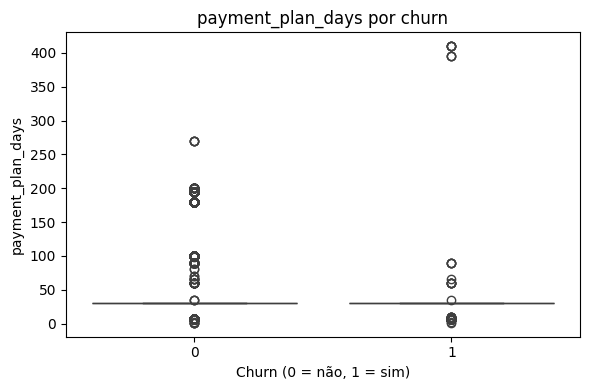

,count,mean,median,std,min,max
target,,,,,,
0,71644,32.130199,30.0,18.293103,1.0,270.0
1,6514,27.276174,30.0,15.585202,1.0,410.0



📈 Analisando variável quantitativa: bd


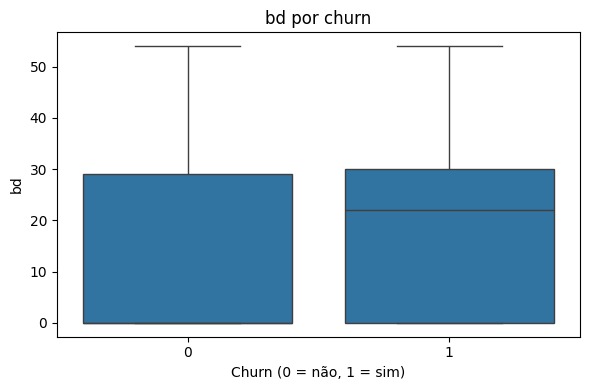

,count,mean,median,std,min,max
target,,,,,,
0,83095,15.019075,0.0,16.284294,0.0,54.0
1,10878,18.921953,22.0,15.305046,0.0,54.0



📈 Analisando variável quantitativa: plan_list_price


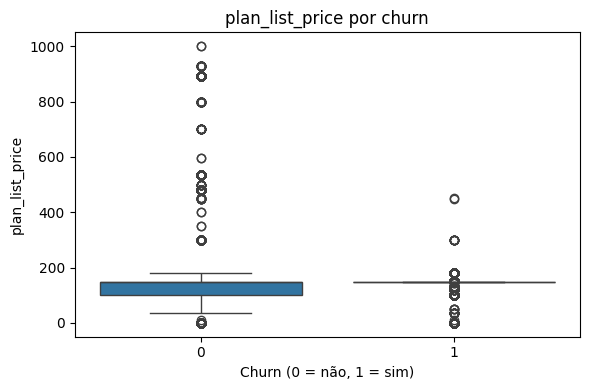

,count,mean,median,std,min,max
target,,,,,,
0,71644,141.275543,149.0,80.386864,0.0,1000.0
1,6514,129.731348,149.0,55.567822,0.0,450.0



📈 Analisando variável quantitativa: actual_amount_paid


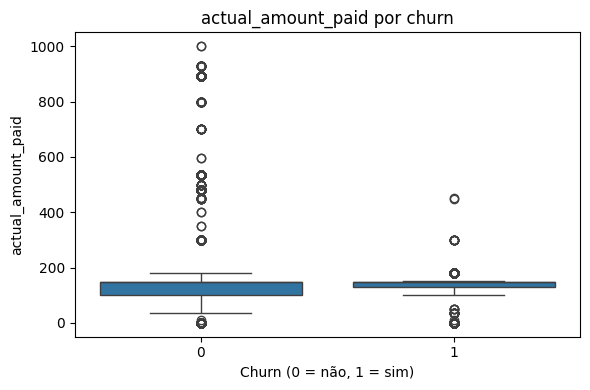

,count,mean,median,std,min,max
target,,,,,,
0,71644,140.957345,149.0,80.650127,0.0,1000.0
1,6514,121.621431,149.0,62.603432,0.0,450.0



📈 Analisando variável quantitativa: days_since_transaction


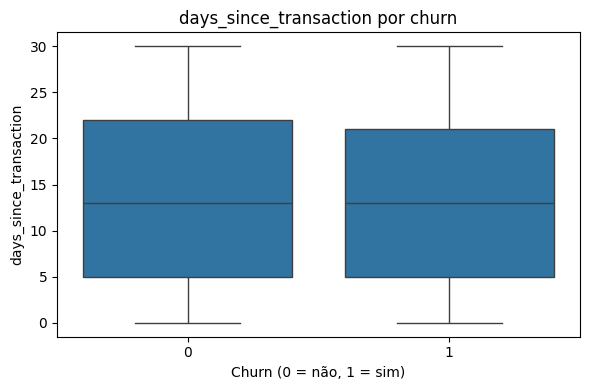

,count,mean,median,std,min,max
target,,,,,,
0,71644,13.234549,13.0,9.499612,0.0,30.0
1,6514,13.321461,13.0,8.936173,0.0,30.0



📈 Analisando variável quantitativa: days_until_membership_expire


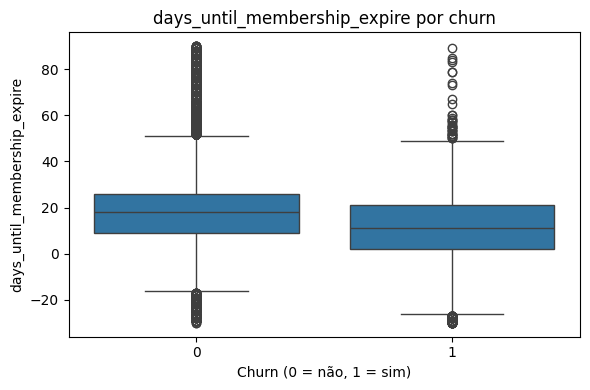

,count,mean,median,std,min,max
target,,,,,,
0,70474,18.567046,18.0,12.431867,-30.0,90.0
1,6512,10.085227,11.0,15.213687,-30.0,89.0



📈 Analisando variável quantitativa: days_since_registration


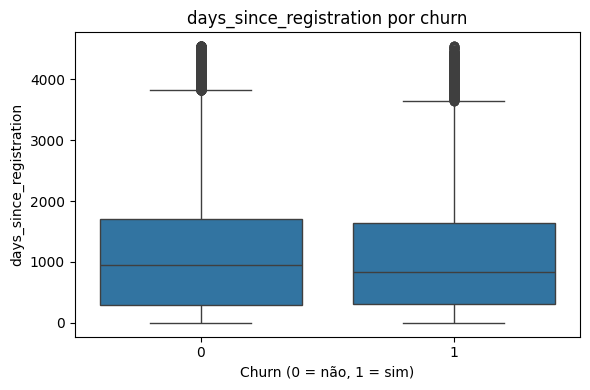

,count,mean,median,std,min,max
target,,,,,,
0,83095,1190.297900,948.0,1069.903204,0.0,4541.0
1,10878,1138.109763,843.0,1051.883783,0.0,4540.0



📈 Analisando variável quantitativa: num_25


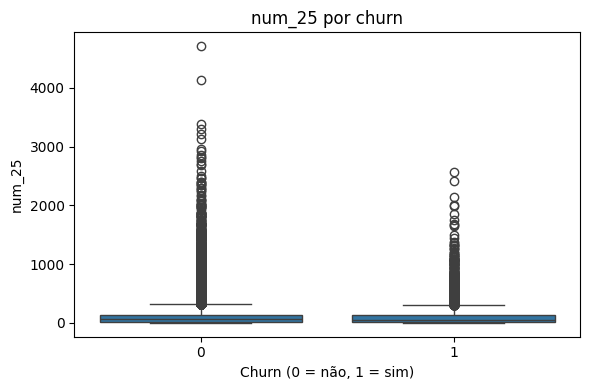

,count,mean,median,std,min,max
target,,,,,,
0,74597,115.194968,60.0,171.673689,0.0,4707.0
1,9470,104.223654,52.0,159.280481,0.0,2574.0



📈 Analisando variável quantitativa: num_50


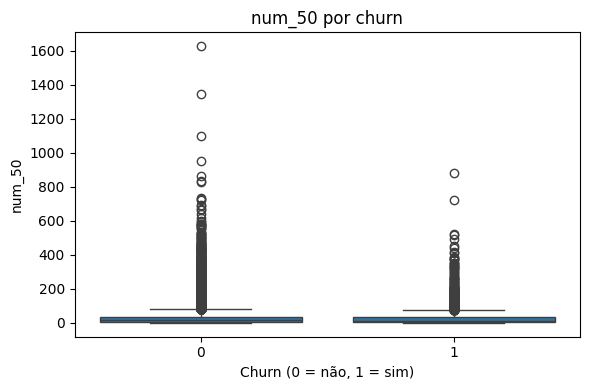

,count,mean,median,std,min,max
target,,,,,,
0,74597,29.016985,16.0,41.105563,0.0,1627.0
1,9470,26.039282,13.0,39.039792,0.0,881.0



📈 Analisando variável quantitativa: num_75


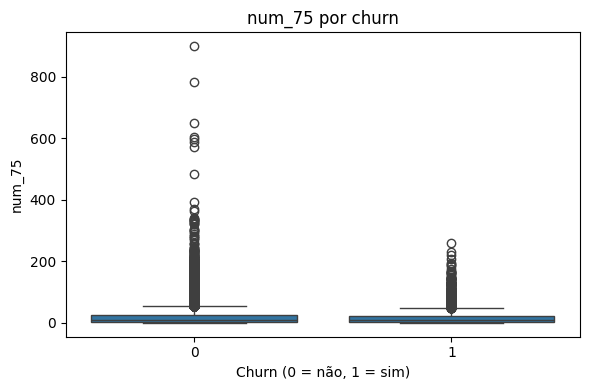

,count,mean,median,std,min,max
target,,,,,,
0,74597,18.181643,11.0,23.668108,0.0,899.0
1,9470,15.971067,9.0,21.194621,0.0,258.0



📈 Analisando variável quantitativa: num_985


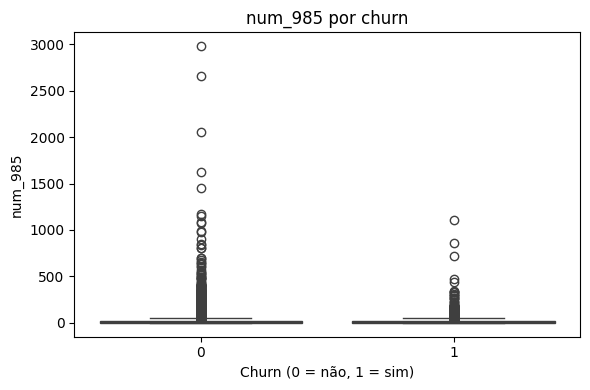

,count,mean,median,std,min,max
target,,,,,,
0,74597,20.141762,11.0,35.853469,0.0,2978.0
1,9470,17.671700,9.0,30.263092,0.0,1109.0



📈 Analisando variável quantitativa: num_100


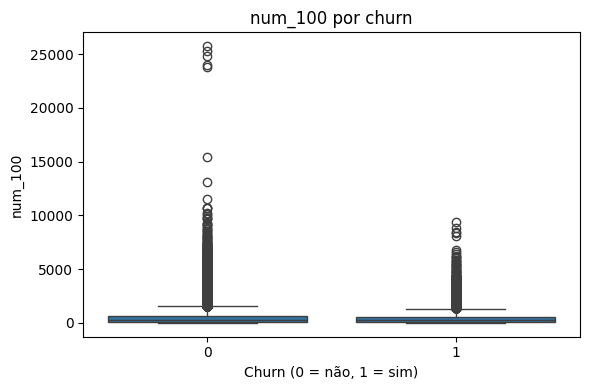

,count,mean,median,std,min,max
target,,,,,,
0,74597,547.075673,313.0,770.683462,0.0,25744.0
1,9470,473.576241,241.0,691.057923,0.0,9378.0



📈 Analisando variável quantitativa: num_unq


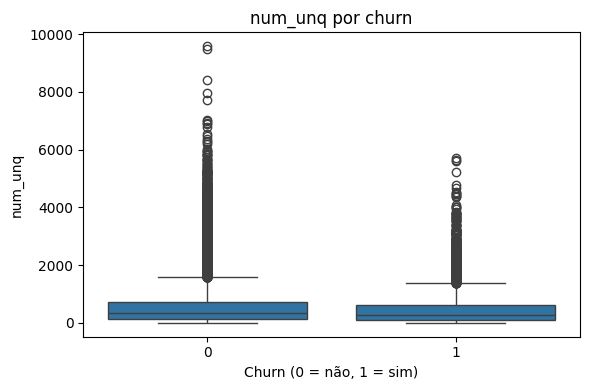

,count,mean,median,std,min,max
target,,,,,,
0,74597,535.732724,349.0,611.598716,1.0,9583.0
1,9470,451.946568,264.0,559.569943,1.0,5705.0



📈 Analisando variável quantitativa: total_secs


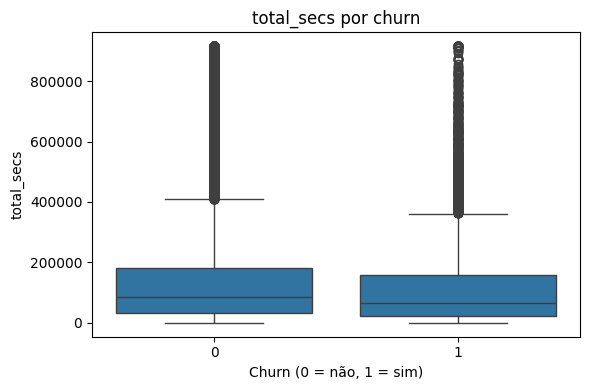

,count,mean,median,std,min,max
target,,,,,,
0,74597,141394.469321,86232.381,168222.929157,0.000,915611.0
1,9470,123659.687113,67067.708,159151.123955,0.888,915611.0


In [21]:
analisar_quanti(df_treino, variaveis_quanti)

### análise qualitativas

In [22]:
def analisar_quali(df, cols_quali, target="target"):
    import matplotlib.pyplot as plt
    import seaborn as sns

    for col_name in cols_quali:
        print(f"\n📊 Analisando variável qualitativa: {col_name}")

        # Substitui valores nulos ou vazios por 'Desconhecido'
        df_col = df.withColumn(
            col_name,
            F.when(F.col(col_name).isNull() | (F.trim(F.col(col_name)) == ""), F.lit("Desconhecido"))
             .otherwise(F.col(col_name))
        )

        # Cálculo das distribuições
        dist_df = (
            df_col.groupBy(col_name, target)
              .agg(F.count("*").alias("count"))
              .groupBy(col_name)
              .pivot(target)
              .agg(F.first("count"))
              .fillna(0)
              .withColumnRenamed("0", "no_churn")
              .withColumnRenamed("1", "churn")
        )

        dist_df = (
            dist_df
            .withColumn("total", F.col("no_churn") + F.col("churn"))
            .withColumn("pct_churn", (F.col("churn") / F.col("total")) * 100)
            .orderBy(F.desc("pct_churn"))
        )

        pdf = dist_df.toPandas()

        # Plot
        plt.figure(figsize=(8, 4))
        ax = sns.barplot(x=col_name, y="pct_churn", data=pdf) # Capture the axes object
        plt.title(f"Taxa de churn por {col_name}")
        plt.ylabel("Churn (%)")
        plt.xticks(rotation=45, ha="right")

        # Add labels to the bars
        for container in ax.containers:
            ax.bar_label(container, fmt='%.2f%%')

        plt.tight_layout()
        plt.show()



📊 Analisando variável qualitativa: payment_method_id


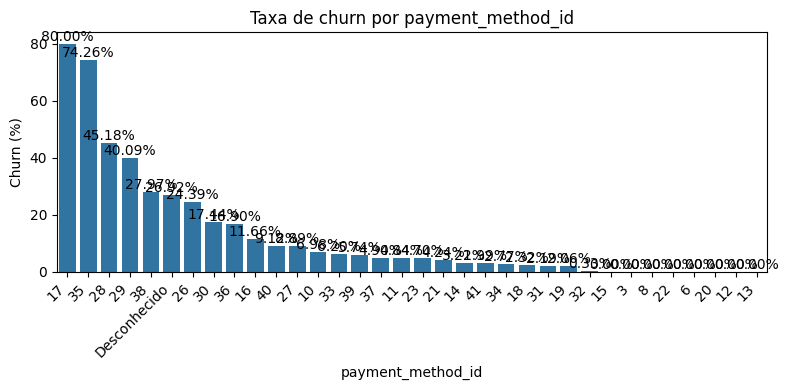


📊 Analisando variável qualitativa: is_auto_renew


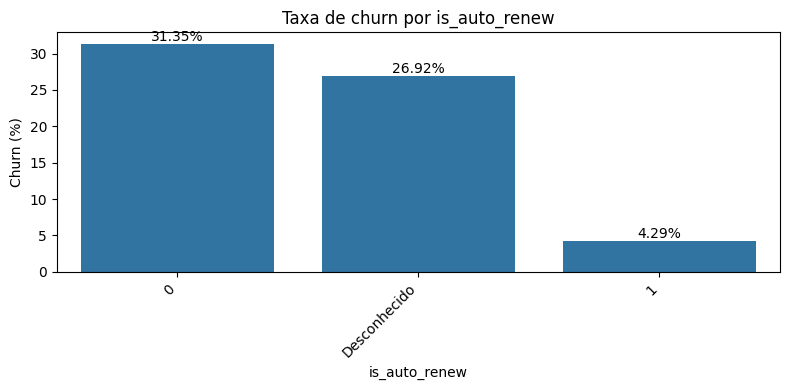


📊 Analisando variável qualitativa: is_cancel


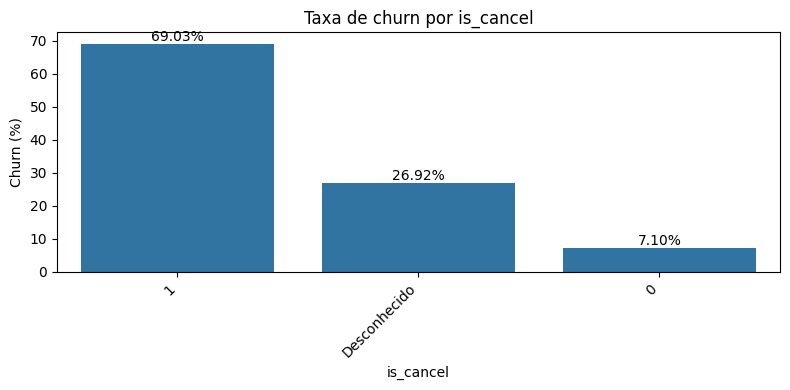


📊 Analisando variável qualitativa: city


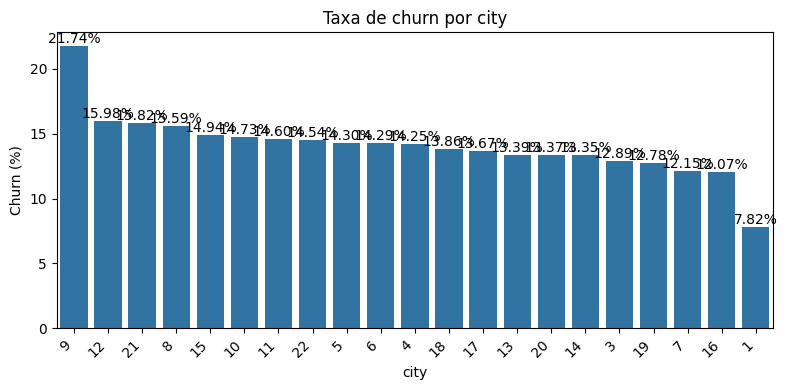


📊 Analisando variável qualitativa: gender


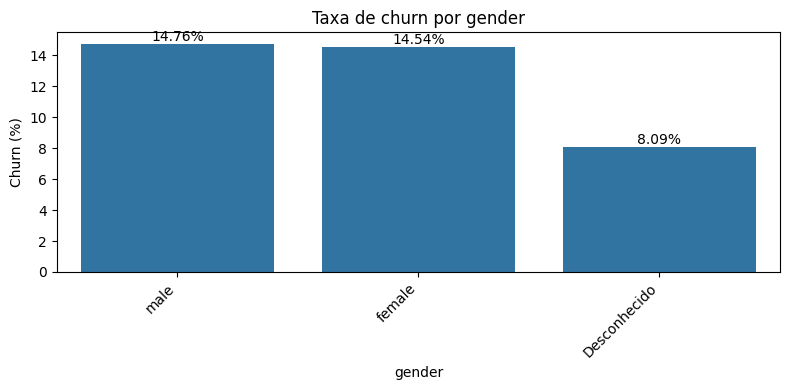


📊 Analisando variável qualitativa: registered_via


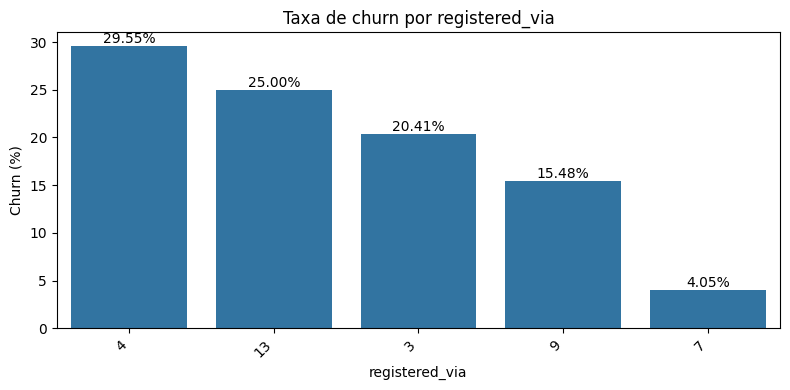

In [23]:
analisar_quali(df_treino, variaveis_quali)

# Feature Engineering

para análise já foram criadas previamente variaveis de tempo desde a data de registro, pagamento e data até a assinatura expirar

prox passos:

* construção da base final e feature engineering
* treino/teste/oot
* modelagem


In [31]:
# ------------------------------ #
#  IV/WOE com OptimalBinning (robusto)
# ------------------------------ #
import warnings
warnings.filterwarnings(
    "ignore",
    message=".*'force_all_finite' was renamed to 'ensure_all_finite'.*",
    category=FutureWarning
)

import pandas as pd
import numpy as np
from optbinning import OptimalBinning
import matplotlib.pyplot as plt

def _prep_pdf(pdf, cols, target):
    cols_ok = [c for c in cols if c in pdf.columns]
    if not cols_ok:
        raise ValueError("Nenhuma coluna de 'cols' existe no DataFrame.")
    df = pdf[[target] + cols_ok].copy()
    # target binário
    df[target] = pd.to_numeric(df[target], errors="coerce").astype("Int64")
    df = df[df[target].isin([0, 1])].copy()
    # substituir ±inf por NaN
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    return df, cols_ok

def _group_rare(pdf_col: pd.Series, min_share=0.01, top_k=30, other_label="OUTROS"):
    """Agrupa categorias raras e limita top_k para estabilizar o OB."""
    s = pdf_col.value_counts(normalize=True, dropna=False)
    keep = set(s.head(top_k).index) | set(s[s >= min_share].index)
    return pdf_col.where(pdf_col.isin(keep), other_label)

def _fit_optbin_categorical(x: pd.Series, y: pd.Series,
                            min_bin_size=0.05, prebin="cart",
                            special_codes=("Desconhecido", "OUTROS")):
    """Fit robusto para categóricas."""
    # imput simples + agrupar raras
    x = x.astype("string").fillna("Desconhecido")
    x = _group_rare(x, min_share=0.01, top_k=30, other_label="OUTROS")

    # arrays
    x_fit = x.astype(object).to_numpy()
    y_fit = y.astype(int).to_numpy()

    # 1ª tentativa (solver CP)
    try:
        ob = OptimalBinning(
            name=x.name, dtype="categorical",
            prebinning_method=prebin,
            min_bin_size=min_bin_size,
            solver="cp",
            special_codes=list(special_codes)
        )
        ob.fit(x_fit, y_fit)
        return ob
    except Exception:
        # 2ª tentativa: relaxar min_bin_size e trocar solver
        ob = OptimalBinning(
            name=x.name, dtype="categorical",
            prebinning_method=prebin,
            min_bin_size=max(0.02, min_bin_size/2),
            solver="mip",
            special_codes=list(special_codes)
        )
        ob.fit(x_fit, y_fit)
        return ob

def _fit_optbin_numeric(x: pd.Series, y: pd.Series,
                        prebin="mdlp",
                        min_prebin_size=0.03, max_n_prebins=20,
                        min_bin_size=0.05, monotonic_trend=None):
    """Fit robusto para numéricas."""
    x = pd.to_numeric(x, errors="coerce")
    # dropar NaN somente para ajuste
    mask = x.notna() & y.notna()
    x_fit = x[mask].to_numpy(dtype=float)
    y_fit = y[mask].astype(int).to_numpy()

    # 1ª tentativa
    try:
        ob = OptimalBinning(
            name=x.name, dtype="numerical",
            prebinning_method=prebin,
            min_prebin_size=min_prebin_size,
            max_n_prebins=max_n_prebins,
            min_bin_size=min_bin_size,
            solver="cp",
            monotonic_trend=monotonic_trend
        )
        ob.fit(x_fit, y_fit)
        return ob
    except Exception:
        # 2ª tentativa: relaxar prebin e trocar solver
        ob = OptimalBinning(
            name=x.name, dtype="numerical",
            prebinning_method="quantile",  # mais permissivo
            min_prebin_size=max(0.02, min_prebin_size/2),
            max_n_prebins=min(15, max_n_prebins),
            min_bin_size=max(0.03, min_bin_size/2),
            solver="mip",
            monotonic_trend=None
        )
        ob.fit(x_fit, y_fit)
        return ob

def analisar_iv_woe_optbin(pdf: pd.DataFrame,
                            cols: list,
                            target: str,
                            tipo: str = "auto",
                            plot: bool = False):
    """
    OptimalBinning para quantitativas e qualitativas (com robustez).
    - pdf: DataFrame Pandas
    - cols: lista de variáveis
    - target: nome do target (0/1)
    - tipo: 'quanti', 'quali' ou 'auto'
    - plot: plota WOE por bin (opcional)
    Retorna: {'detalhes': DataFrame, 'resumo': DataFrame}
    """
    df, use_cols = _prep_pdf(pdf, cols, target)
    detalhes_list, resumo_list = [], []

    for col in use_cols:
        # detectar tipo
        if tipo == "auto":
            is_quali = (df[col].dtype == "object"
                        or df[col].dtype.name == "string"
                        or df[col].nunique(dropna=True) < 10)
            tipo_var = "quali" if is_quali else "quanti"
        else:
            tipo_var = tipo

        y = df[target].astype(int)

        try:
            if tipo_var == "quali":
                ob = _fit_optbin_categorical(df[col], y,
                                             min_bin_size=0.05,
                                             prebin="cart")
            else:
                ob = _fit_optbin_numeric(df[col], y,
                                         prebin="mdlp",
                                         min_prebin_size=0.03,
                                         max_n_prebins=20,
                                         min_bin_size=0.05,
                                         monotonic_trend=None)

            # tabela
            bt = ob.binning_table.build().reset_index()
            bin_col = bt.columns[0]  # nome da coluna de rótulo de bin
            iv_total = float(ob.binning_table.iv)

            # share (%)
            if "Count" in bt.columns:
                totals_mask = bt[bin_col].astype(str).str.lower().eq("totals")
                if totals_mask.any():
                    total = float(bt.loc[totals_mask, "Count"].values[0])
                    if np.isfinite(total) and total > 0:
                        bt["Share_%"] = (bt["Count"] / total) * 100.0

            bt["variavel"] = col
            bt["tipo"] = tipo_var
            detalhes_list.append(bt)
            resumo_list.append({"variavel": col, "iv": iv_total, "tipo": tipo_var})

            # plot opcional
            if plot and "WoE" in bt.columns:
                bins_only = bt[~bt[bin_col].astype(str).str.lower().eq("totals")]
                plt.figure(figsize=(6,4))
                plt.bar(bins_only[bin_col].astype(str), bins_only["WoE"])
                plt.title(f"WOE por bin - {col} (IV={iv_total:.4f})")
                plt.xticks(rotation=45, ha="right")
                plt.tight_layout()
                plt.show()

        except Exception as e:
            print(f"⚠️ OptimalBinning falhou em {col}: {e}")
            # registra variável como falha (sem cair para manual)
            resumo_list.append({"variavel": col, "iv": np.nan, "tipo": tipo_var})

    df_det = pd.concat(detalhes_list, ignore_index=True) if detalhes_list else pd.DataFrame()
    df_res = pd.DataFrame(resumo_list)
    if not df_res.empty:
        df_res = df_res.sort_values(["iv", "variavel"], ascending=[False, True], na_position="last")
    return {"detalhes": df_det, "resumo": df_res}


In [32]:
pdf_treino = df_treino.toPandas()

In [38]:
res_quanti = analisar_iv_woe_optbin(pdf_treino, variaveis_quanti, target="target", tipo="quanti", plot=False)
res_quali  = analisar_iv_woe_optbin(pdf_treino, variaveis_quali,  target="target", tipo="quali",  plot=False)


In [39]:
res_quanti


{'detalhes':       index                     Bin   Count  Count (%)  Non-event  Event  \
 0         0             (-inf, inf)  780853   1.000000     715843  65010   
 1         1                 Special       0   0.000000          0      0   
 2         2                 Missing       0   0.000000          0      0   
 3    Totals                          780853   1.000000     715843  65010   
 4         0            (-inf, 3.47)  455336   0.484515     418596  36740   
 ..      ...                     ...     ...        ...        ...    ...   
 139       6  [133585.16, 364918.14)  219684   0.261116     198911  20773   
 140       7        [364918.14, inf)   70869   0.084235      63478   7391   
 141       8                 Special       0   0.000000          0      0   
 142       9                 Missing       0   0.000000          0      0   
 143  Totals                          841326   1.000000     747584  93742   
 
      Event rate       WoE        IV        JS     Share_%    

In [40]:
res_quanti["detalhes"]

,index,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Share_%,variavel,tipo
0,0,"(-inf, inf)",780853,1.000000,715843,65010,0.083255,0.0,0.000000,0.000000,100.000000,payment_plan_days,quanti
1,1,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000,0.000000,payment_plan_days,quanti
2,2,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000,0.000000,payment_plan_days,quanti
3,Totals,,780853,1.000000,715843,65010,0.083255,,0.000000,0.000000,100.000000,payment_plan_days,quanti
4,0,"(-inf, 3.47)",455336,0.484515,418596,36740,0.080688,0.389378,0.063184,0.007848,48.451546,bd,quanti
...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,6,"[133585.16, 364918.14)",219684,0.261116,198911,20773,0.094559,0.182903,0.008134,0.001015,26.111638,total_secs,quanti
140,7,"[364918.14, inf)",70869,0.084235,63478,7391,0.104291,0.07413,0.000450,0.000056,8.423489,total_secs,quanti
141,8,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000,0.000000,total_secs,quanti
142,9,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000,0.000000,total_secs,quanti


In [41]:
res_quali

{'detalhes':      index                                   Bin   Count  Count (%)  \
 0        0  [13, 12, 22, 20, 32, 19, 31, 18, 34]   51509   0.054810   
 1        1                              [41, 14]  422822   0.449918   
 2        2          [21, 23, 11, 37, 39, 33, 10]   91039   0.096873   
 3        3                  [27, 40, 16, 36, 30]  127965   0.136165   
 4        4              [26, 38, 29, 28, 35, 17]   87457   0.093062   
 5        5                               Special  158984   0.169172   
 6        6                               Missing       0   0.000000   
 7   Totals                                        939776   1.000000   
 8        0                                   [1]  664456   0.707037   
 9        1                                   [0]  116397   0.123856   
 10       2                               Special  158923   0.169107   
 11       3                               Missing       0   0.000000   
 12  Totals                                        9

In [42]:
res_quali["detalhes"]

,index,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Share_%,variavel,tipo
0,0,"[13, 12, 22, 20, 32, 19, 31, 18, 34]",51509,0.054810,50361,1148,0.022287,1.737534,0.086669,0.009648,5.480987,payment_method_id,quali
1,1,"[41, 14]",422822,0.449918,410158,12664,0.029951,1.434117,0.538502,0.062079,44.991785,payment_method_id,quali
2,2,"[21, 23, 11, 37, 39, 33, 10]",91039,0.096873,86086,4953,0.054405,0.811691,0.046687,0.005681,9.687308,payment_method_id,quali
3,3,"[27, 40, 16, 36, 30]",127965,0.136165,112869,15096,0.117970,-0.031864,0.000140,0.000017,13.616543,payment_method_id,quali
4,4,"[26, 38, 29, 28, 35, 17]",87457,0.093062,56308,31149,0.356164,-1.451608,0.321252,0.036965,9.306154,payment_method_id,quali
5,5,Special,158984,0.169172,116207,42777,0.269065,-1.04429,0.268583,0.032126,16.917223,payment_method_id,quali
6,6,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000,0.000000,payment_method_id,quali
7,Totals,,939776,1.000000,831989,107787,0.114694,,1.261833,0.146517,100.000000,payment_method_id,quali
8,0,[1],664456,0.707037,635932,28524,0.042928,1.060684,0.530043,0.063314,70.703657,is_auto_renew,quali
9,1,[0],116397,0.123856,79911,36486,0.313462,-1.259677,0.305412,0.035837,12.385611,is_auto_renew,quali


In [44]:
from pyspark.sql import functions as F

# Exemplo: ver se payment_method_id muda antes do churn
df_check = df_treino.groupBy("safra") \
    .agg(F.countDistinct("payment_method_id").alias("n_payment_methods"),
         F.countDistinct("is_auto_renew").alias("n_auto_renew_flags"))

df_check.describe().show()


+-------+------------------+------------------+------------------+
|summary|             safra| n_payment_methods|n_auto_renew_flags|
+-------+------------------+------------------+------------------+
|  count|                 5|                 5|                 5|
|   mean|          201606.0|              32.2|               2.0|
| stddev|1.5811388300834228|0.4472135954999583|               0.0|
|    min|            201604|                32|                 2|
|    max|            201608|                33|                 2|
+-------+------------------+------------------+------------------+

